# Imports

In [1]:
import graph_tool.topology
import tqdm
from graph_tool.all import *
import os
import sys
import shutil
import math
from typing import *
from enum import Enum
import datetime
import numpy as np
import pandas as pd
from MotifSignifanceCalculationForPHDProp import *
import matplotlib.pyplot as plt
import plotly.express as px

# Reading a sample graph (a subgraph of the complete graph)

In [2]:
exp_graph_path = '/Users/yishaiazabary/PycharmProjects/University/BrainVasculatureGraphs/Data/GBM_Tumor_Graphs/gbm_graph_enriched_with_edge_volume.gt'
g = load_graph(exp_graph_path)

In [3]:
print(f"Raw graph basic attributes:")
print(f"#vertices: {g.num_vertices()}, #edges: {g.num_edges()}")

Raw graph basic attributes:
#vertices: 167647, #edges: 208628


In [4]:
g.list_properties()

shape                           (graph)   (type: python::object, val: (2160,
                                                                      2560,
                                                                      1784))
edge_geometry_type              (graph)   (type: python::object, val: graph)
edge_geometry_coordinates       (graph)   (type: python::object, val: [[1.18000
                                                                      000e+02 9
                                                                      .83000000
                                                                      e+02 1.00
                                                                      000000e+0
                                                                      0]  [1.17
                                                                      000000e+0
                                                                      2 9.83000
                                                     

# Cleaning the graph

In [4]:
remove_parallel_edges(g)
remove_self_loops(g)

In [5]:
print(f"Graph basic attributes with self loops and parallel edges removed:")
print(f"#vertices: {g.num_vertices()}, #edges: {g.num_edges()}")
print(f"graph is {''if g.is_directed() else 'not'} directed")

Graph basic attributes with self loops and parallel edges removed:
#vertices: 167647, #edges: 196881
graph is not directed


# drawing the graph

In [9]:
graph_draw(g, pos=g.vp['coordinates'], output='gbm_1st_graph.pdf')

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x15cc29180, at 0x15c9b0c10>

# immune cells presence

In [11]:
np.unique(g.ep['artery_raw'].a, return_counts=True)

(PropertyArray([  127.,   132.,   136., ..., 15730., 16948., 30324.]),
 array([1, 4, 2, ..., 3, 7, 1]))

## Immune cell presence in edges by radii

### Calculate graph edges attribute bins

In [6]:
def get_all_edges_attribute(g: Graph, attribute_to_get: Tuple[str, str]=("e", "radii")) -> np.array:
        return g.properties[attribute_to_get].a

def calculate_attribute_bins(data: np.array, n_bins: int=4, **kwargs)->np.array:
    sorted_data = sorted(data, key=kwargs.get("sorting_key_func", lambda x: x))
    n_data_points_per_bin = data.shape[0] // n_bins
    data_partitioned_to_bins = np.vstack([sorted_data[_ * n_data_points_per_bin: (_+1)*n_data_points_per_bin] for _ in range(n_bins)])
    bins_limits = np.array([np.min(bin_data) for bin_data in data_partitioned_to_bins])
    if kwargs.get("return_bins_limits", True):
        return data_partitioned_to_bins, bins_limits
    else:
        return data_partitioned_to_bins
    
def plot_basic_binning_partitions_attributes(data: np.array, data_partitioned_to_bins: np.array, bins_limits: np.array)->None:
    fig, axis = plt.subplots(1,4)
    axis[0].boxplot(data)
    axis[0].set_title("All attribute values")
    axis[1].scatter([_ for _, partition in enumerate(data_partitioned_to_bins)], [len(partition) for _, partition in enumerate(data_partitioned_to_bins)])
    axis[1].set_title("N values in each bin (a sanity check for binning partition)")
    axis[2].scatter([_ for _, partition in enumerate(bins_limits)], [partition for _, partition in enumerate(bins_limits)])
    axis[2].set_title("Bin limits (a sanity check for bining partition)")
    axis[3].scatter([_ for _, partition in enumerate(data_partitioned_to_bins)], [np.std(partition) for _, partition in enumerate(data_partitioned_to_bins)])
    axis[2].set_title("Bin values STD (a sanity check for bining partition)")
    plt.tight_layout()
    plt.show()

In [13]:
graph_edges_radiis = get_all_edges_attribute(g)
graph_edges_lengths = get_all_edges_attribute(g, attribute_to_get=("e", "edge_volume"))

radii_partitioned_to_bins, radii_bins_limits = calculate_attribute_bins(data=graph_edges_radiis)
length_partitioned_to_bins, length_bins_limits = calculate_attribute_bins(data=graph_edges_lengths)

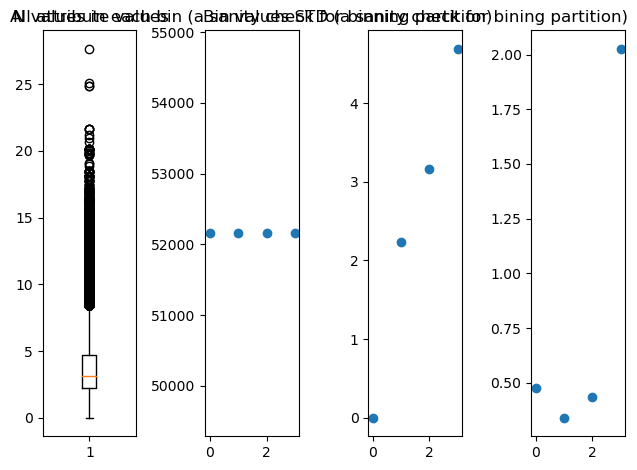

In [14]:
plot_basic_binning_partitions_attributes(data=graph_edges_radiis, data_partitioned_to_bins=radii_partitioned_to_bins, bins_limits=radii_bins_limits)

In [7]:
def partition_edges_to_attribute_bins(_g: Graph, bins: np.array, attribute: str='radii', **kwargs) -> Union[List[List[Edge]], Tuple[List[List[Edge]], List[List[Any]]]]:
        edges_in_bins = [[] for _ in range(len(bins))]
        attribute_to_collect_values = [[] for _ in range(len(bins))]
        for edge_idx, edge in enumerate(_g.edges()):
            edge_attribute_value = g.ep[attribute][edge]
            edge_bin_idx = np.digitize(edge_attribute_value, bins=bins, right=kwargs.get("bin_includes_right_lim_value", False))
            edges_in_bins[edge_bin_idx-1].append(edge)
            attribute_to_collect_values[edge_bin_idx-1].append(g.ep[kwargs.get("attribute_to_collect", "artery_raw")][edge])
        if kwargs.get("return_edges_attributes_values", True):
            return edges_in_bins, attribute_to_collect_values
        return edges_in_bins

def plot_binning_values_basics_as_boxplots(partitioned_bins_values: Union[np.array, List[List[Union[int, float]]]], bin_limits: Union[np.array, None]=None, attribute_partitioned_by: Union[str, None] = None,
                                               **kwargs) -> None:
    fig, axis = plt.subplots(1,2)
    axis[0].boxplot([np.log10(x) if kwargs.get("y_as_log", False) else x for x in partitioned_bins_values])
    axis[0].set_title(f"Binning partition values distribution")
    if bin_limits is not None and attribute_partitioned_by is not None:
        axis[0].set_xticks(np.arange(1, len(bin_limits)+1, 1))
        axis[0].set_xticklabels([f"{partition:.2f} - {f'{bin_limits[_ + 1]:.2f}' if len(bin_limits)-1 > _ else 'inf'}" for _, partition in enumerate(bin_limits)], rotation=90)
        axis[0].set_xlabel(f"Bins by {attribute_partitioned_by}")

    if kwargs.get("y_as_log"):
        # axis[0].set_yticks([10**x for x in range(5)])
        axis[0].set_yticklabels([f"{10 ** x}" for x in range(7)])
        axis[0].set_ylabel(f"Log {kwargs.get('axis_0_y_label', 'Immune cells raw intensity')}")

    axis[1].scatter(np.arange(0, len(partitioned_bins_values), 1),  [len(bin_vals) for bin_vals in partitioned_bins_values])
    axis[1].set_title(f"Binning partition values counts")
    axis[1].set_ylabel(f"{kwargs.get('axis_1_y_label', 'Immune cells count')}")
    if bin_limits is not None and attribute_partitioned_by is not None:
        axis[1].set_xticks(np.arange(0, len(bin_limits), 1))
        axis[1].set_xticklabels([f"{partition:.2f} - {f'{bin_limits[_ + 1]:.2f}' if len(bin_limits)-1 > _ else 'inf'}" for _, partition in enumerate(bin_limits)], rotation=90)
        axis[1].set_xlabel(f"Bins by {attribute_partitioned_by}")
    plt.tight_layout()
    plt.show()

In [16]:
edges_with_immune_binary_bins_by_edge_radii = partition_edges_to_attribute_bins(
        _g=g,
        bins=radii_bins_limits,
        attribute='edge_volume'
    )

/var/folders/ht/39cw5_7x2fd3jp_n3yprx9vc0000gn/T/ipykernel_2939/1970801567.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis[0].set_yticklabels([f"{10 ** x}" for x in range(7)])


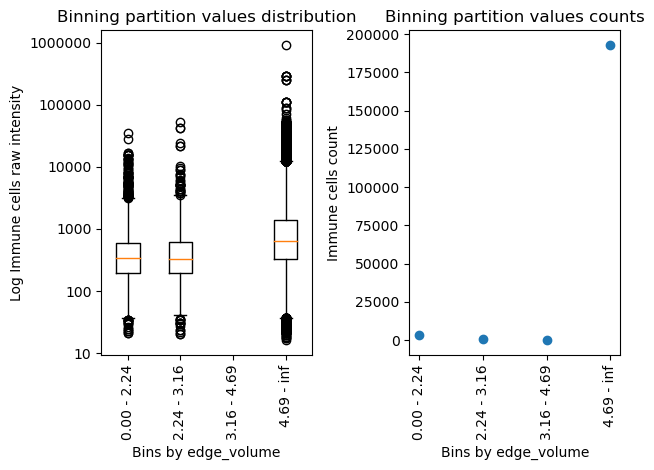

In [17]:
plot_binning_values_basics_as_boxplots(edges_with_immune_binary_bins_by_edge_radii[1],
                                           bin_limits=radii_bins_limits,
                                           attribute_partitioned_by="edge_volume",
                                           axis_0_y_label='Immune cells raw intensity',
                                           axis_1_y_label='Immune cells count',
                                           y_as_log=True)

## Immune cell presence in edges by length

/var/folders/ht/39cw5_7x2fd3jp_n3yprx9vc0000gn/T/ipykernel_2939/1970801567.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis[0].set_yticklabels([f"{10 ** x}" for x in range(7)])


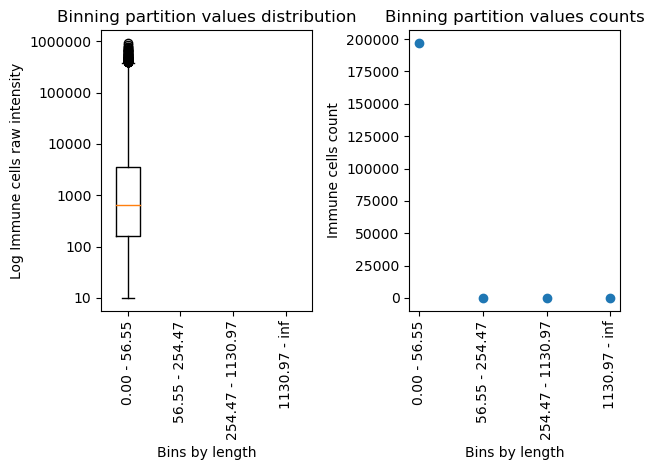

In [18]:
edges_with_immune_binary_bins_by_edge_length = partition_edges_to_attribute_bins(
        _g=g,
        bins=length_bins_limits,
        attribute_to_collect='length')
plot_binning_values_basics_as_boxplots(edges_with_immune_binary_bins_by_edge_length[1],
                                       bin_limits=length_bins_limits,
                                       attribute_partitioned_by='length',
                                       axis_0_y_label='Immune cells raw intensity',
                                       axis_1_y_label='Immune cells count',
                                       y_as_log=True
                                       )

# Calculating "regular" motifs

In [8]:
from graph_tool.clustering import motifs, motif_significance

In [9]:
motif_size = 4
reg_motifs, reg_motifs_zscores, reg_motif_counts, reg_motifs_avg_counts_in_random_graphs, reg_motifs_std_counts_in_random_graphs = motif_significance(g, k=motif_size, full_output=True)

In [10]:
_motifs, motifs_cnts, motifs_vertex_properties = motifs(g, k=motif_size, p=1.0, return_maps=True)

In [11]:
reg_motifs_full_results = list(zip(reg_motifs, reg_motifs_zscores, reg_motif_counts, reg_motifs_avg_counts_in_random_graphs, reg_motifs_std_counts_in_random_graphs))

In [12]:
def get_edge_attribute_values_aggregation_from_lst_of_vertices(g: Graph, motifs_vertices_lst: List[int],
                                                                   attribute_to_aggregate:Tuple[str, str]=('e', 'artery_binary'),
                                                                   aggregation_method=np.sum,
                                                                   repeat_edge_allowed: bool=False):
    visited_edges = set()
    attribute_values_to_aggregate = []
    for vertices_lst in motifs_vertices_lst:
        for vertex_id in vertices_lst:
            v = g.vertex(vertex_id)
            v_edges = v.all_edges()
            v_edges_as_tuples = []
            for edge in v_edges:
                if edge.target() not in vertices_lst:
                    continue
                edge_as_tuple = (edge.source(), edge.target())
                if not repeat_edge_allowed and (edge_as_tuple in visited_edges or edge_as_tuple[::-1] in visited_edges):
                    continue
                v_edges_as_tuples.append(edge_as_tuple)
                edge_attribute_val = g.properties[attribute_to_aggregate][edge]
                attribute_values_to_aggregate.append(edge_attribute_val)
            visited_edges.update(set(v_edges_as_tuples))
    return aggregation_method(attribute_values_to_aggregate)

def get_vertex_attribute_values_aggregation_from_lst_of_vertices(g: Graph, motifs_vertices_lst: List[int],
                                                               attribute_to_aggregate:Tuple[str, str]=('v', 'coordinates'),
                                                               aggregation_method=np.sum):
    attribute_values_to_aggregate = []
    for vertices_lst in motifs_vertices_lst:
        for vertex_id in vertices_lst:
            v = g.vertex(vertex_id)
            attribute_values_to_aggregate.append(g.properties[attribute_to_aggregate][v])

    return aggregation_method(attribute_values_to_aggregate)

### motifs surprise factor

In [15]:
motifs_surprise_factor = [reg_count/rand_avg_count if rand_avg_count!=0 else float('inf') for reg_count, rand_avg_count in zip(reg_motif_counts, reg_motifs_avg_counts_in_random_graphs)]

In [13]:
from MotifSignifanceCalculationForPHDProp import *
motifs_immune_count = {}
_motifs, _motifs_counts, _motifs_vertices_indices = remove_duplicate_motifs_keep_counts_and_vertices_indices(_motifs=_motifs,                                        motifs_cnts=motifs_cnts,                                                                motifs_vertices_indices=motifs_vertex_properties)
for motif, motif_vertex_lsts in zip(_motifs, motifs_vertex_properties):
    motifs_immune_count[motif] = get_edge_attribute_values_aggregation_from_lst_of_vertices(g, motif_vertex_lsts)

## Calculating motifs volumes

In [14]:
from MotifSignifanceCalculationForPHDProp import *
motifs_volume_counts = {}
# _motifs, _motifs_counts, _motifs_vertices_indices = remove_duplicate_motifs_keep_counts_and_vertices_indices(_motifs=_motifs,
#                                    motifs_cnts=motifs_cnts,                  motifs_vertices_indices=motifs_vertex_properties)
for motif, motif_vertex_lsts in zip(_motifs, motifs_vertex_properties):
    motifs_volume_counts[motif] = get_edge_attribute_values_aggregation_from_lst_of_vertices(g, motif_vertex_lsts, attribute_to_aggregate=('e', 'edge_volume'), aggregation_method=lambda x: x)

### Plot #immune cells containing edges in motifs by motif type

In [ ]:
all_motifs_type_colors = {} if "all_motifs_type_colors" not in locals() else all_motifs_type_colors
def tmp_get_flag(motif_type, v_color):
    if not os.path.isdir('tmp'):
        os.makedirs('tmp')
    graph_draw(motif_type, output='tmp/t.png', output_size=(30, 30), vertex_fill_color=v_color)
    path = "tmp/t.png"
    im = plt.imread(path)
    return im

def tmp_get_motif_color(_motif) -> np.array:
    global all_motifs_type_colors
    if all_motifs_type_colors.get(_motif, None) is None:
        motif_type_color = list(np.random.choice(np.arange(0.3, 1., 0.1), size=3)) + [0.9]
        all_motifs_type_colors[_motif] = motif_type_color
    return all_motifs_type_colors[_motif]

def tmp_offset_image(coord, motif_type, ax, **kwargs):
    global all_motifs_type_colors
    v_color = tmp_get_motif_color(motif_type) #all_motifs_type_colors[motif_type]
    img = tmp_get_flag(motif_type, v_color=v_color)
    im = OffsetImage(img, zoom=1)
    im.image.axes = ax
    ab = AnnotationBbox(im, (coord, 0), xybox=kwargs.get("xybox_for_motifs_illustration", (0., -30.)), frameon=False,
                        xycoords='data', boxcoords="offset points", pad=0)

    ax.add_artist(ab)

def tmp_plot_motif_cnts_per_type(motifs_types, valuesA, subgraph_name, path_to_save_plot_dir=None, motifs_len: int = 4):

    # plots with motifs ilustration (graph_draw) as axis labels

    plt.rcParams.update({'font.size': 20})
    fig, ax = plt.subplots(figsize=(30, 20))

    ax.bar(range(len(motifs_types)), valuesA, width=0.5, align="center")
    ax.set_xticks(range(len(motifs_types)))
    ax.set_xticklabels([])
    ax.tick_params(axis='x', which='major', pad=26)

    for bars in ax.containers:
        ax.bar_label(bars)

    ax.set_title(f"{subgraph_name} counts")

    #     plt.tight_layout()

    for i, motif_type in enumerate(motifs_types):
        tmp_offset_image(i, motif_type, ax)
    if path_to_save_plot_dir is None:
        plt.show()
    else:
        path_to_save_plot = os.path.join(path_to_save_plot_dir, f"{subgraph_name}_{motifs_len}.png") if path_to_save_plot_dir != "" else f"{subgraph_name}_{motifs_len}.png"
        plt.savefig(path_to_save_plot, dpi=300)
        path_to_save_plot = os.path.join(path_to_save_plot_dir, f"{subgraph_name}_{motifs_len}.eps") if path_to_save_plot_dir != "" else f"{subgraph_name}_{motifs_len}.eps"
        plt.savefig(path_to_save_plot, dpi=300)

def tmp_plot_motif_cnts_per_type_as_boxolots(motifs_types, valuesA: List[Iterable], subgraph_name: str, path_to_save_plot_dir=None, motifs_len: int = 4, **kwargs):

    # plots with motifs ilustration (graph_draw) as axis labels

    plt.rcParams.update({'font.size': 20})
    fig, ax = plt.subplots(figsize=(30, 20))


    ax.boxplot(valuesA)
    ax.set_xticks(range(len(motifs_types)))
    ax.set_xticklabels([])
    ax.tick_params(axis='x', which='major', pad=26)

    ax.set_title(f"{subgraph_name} values distribution")

    #     plt.tight_layout()

    for i, motif_type in enumerate(motifs_types):
        tmp_offset_image(i+1, motif_type, ax, **kwargs)
    if path_to_save_plot_dir is None:
        plt.show()
    else:
        path_to_save_plot = os.path.join(path_to_save_plot_dir, f"{subgraph_name}_{motifs_len}.png") if path_to_save_plot_dir != "" else f"{subgraph_name}_{motifs_len}.png"
        plt.savefig(path_to_save_plot, dpi=300)
        path_to_save_plot = os.path.join(path_to_save_plot_dir, f"{subgraph_name}_{motifs_len}.eps") if path_to_save_plot_dir != "" else f"{subgraph_name}_{motifs_len}.eps"
        plt.savefig(path_to_save_plot, dpi=300)

### Plot motifs #appearances in network by motif type

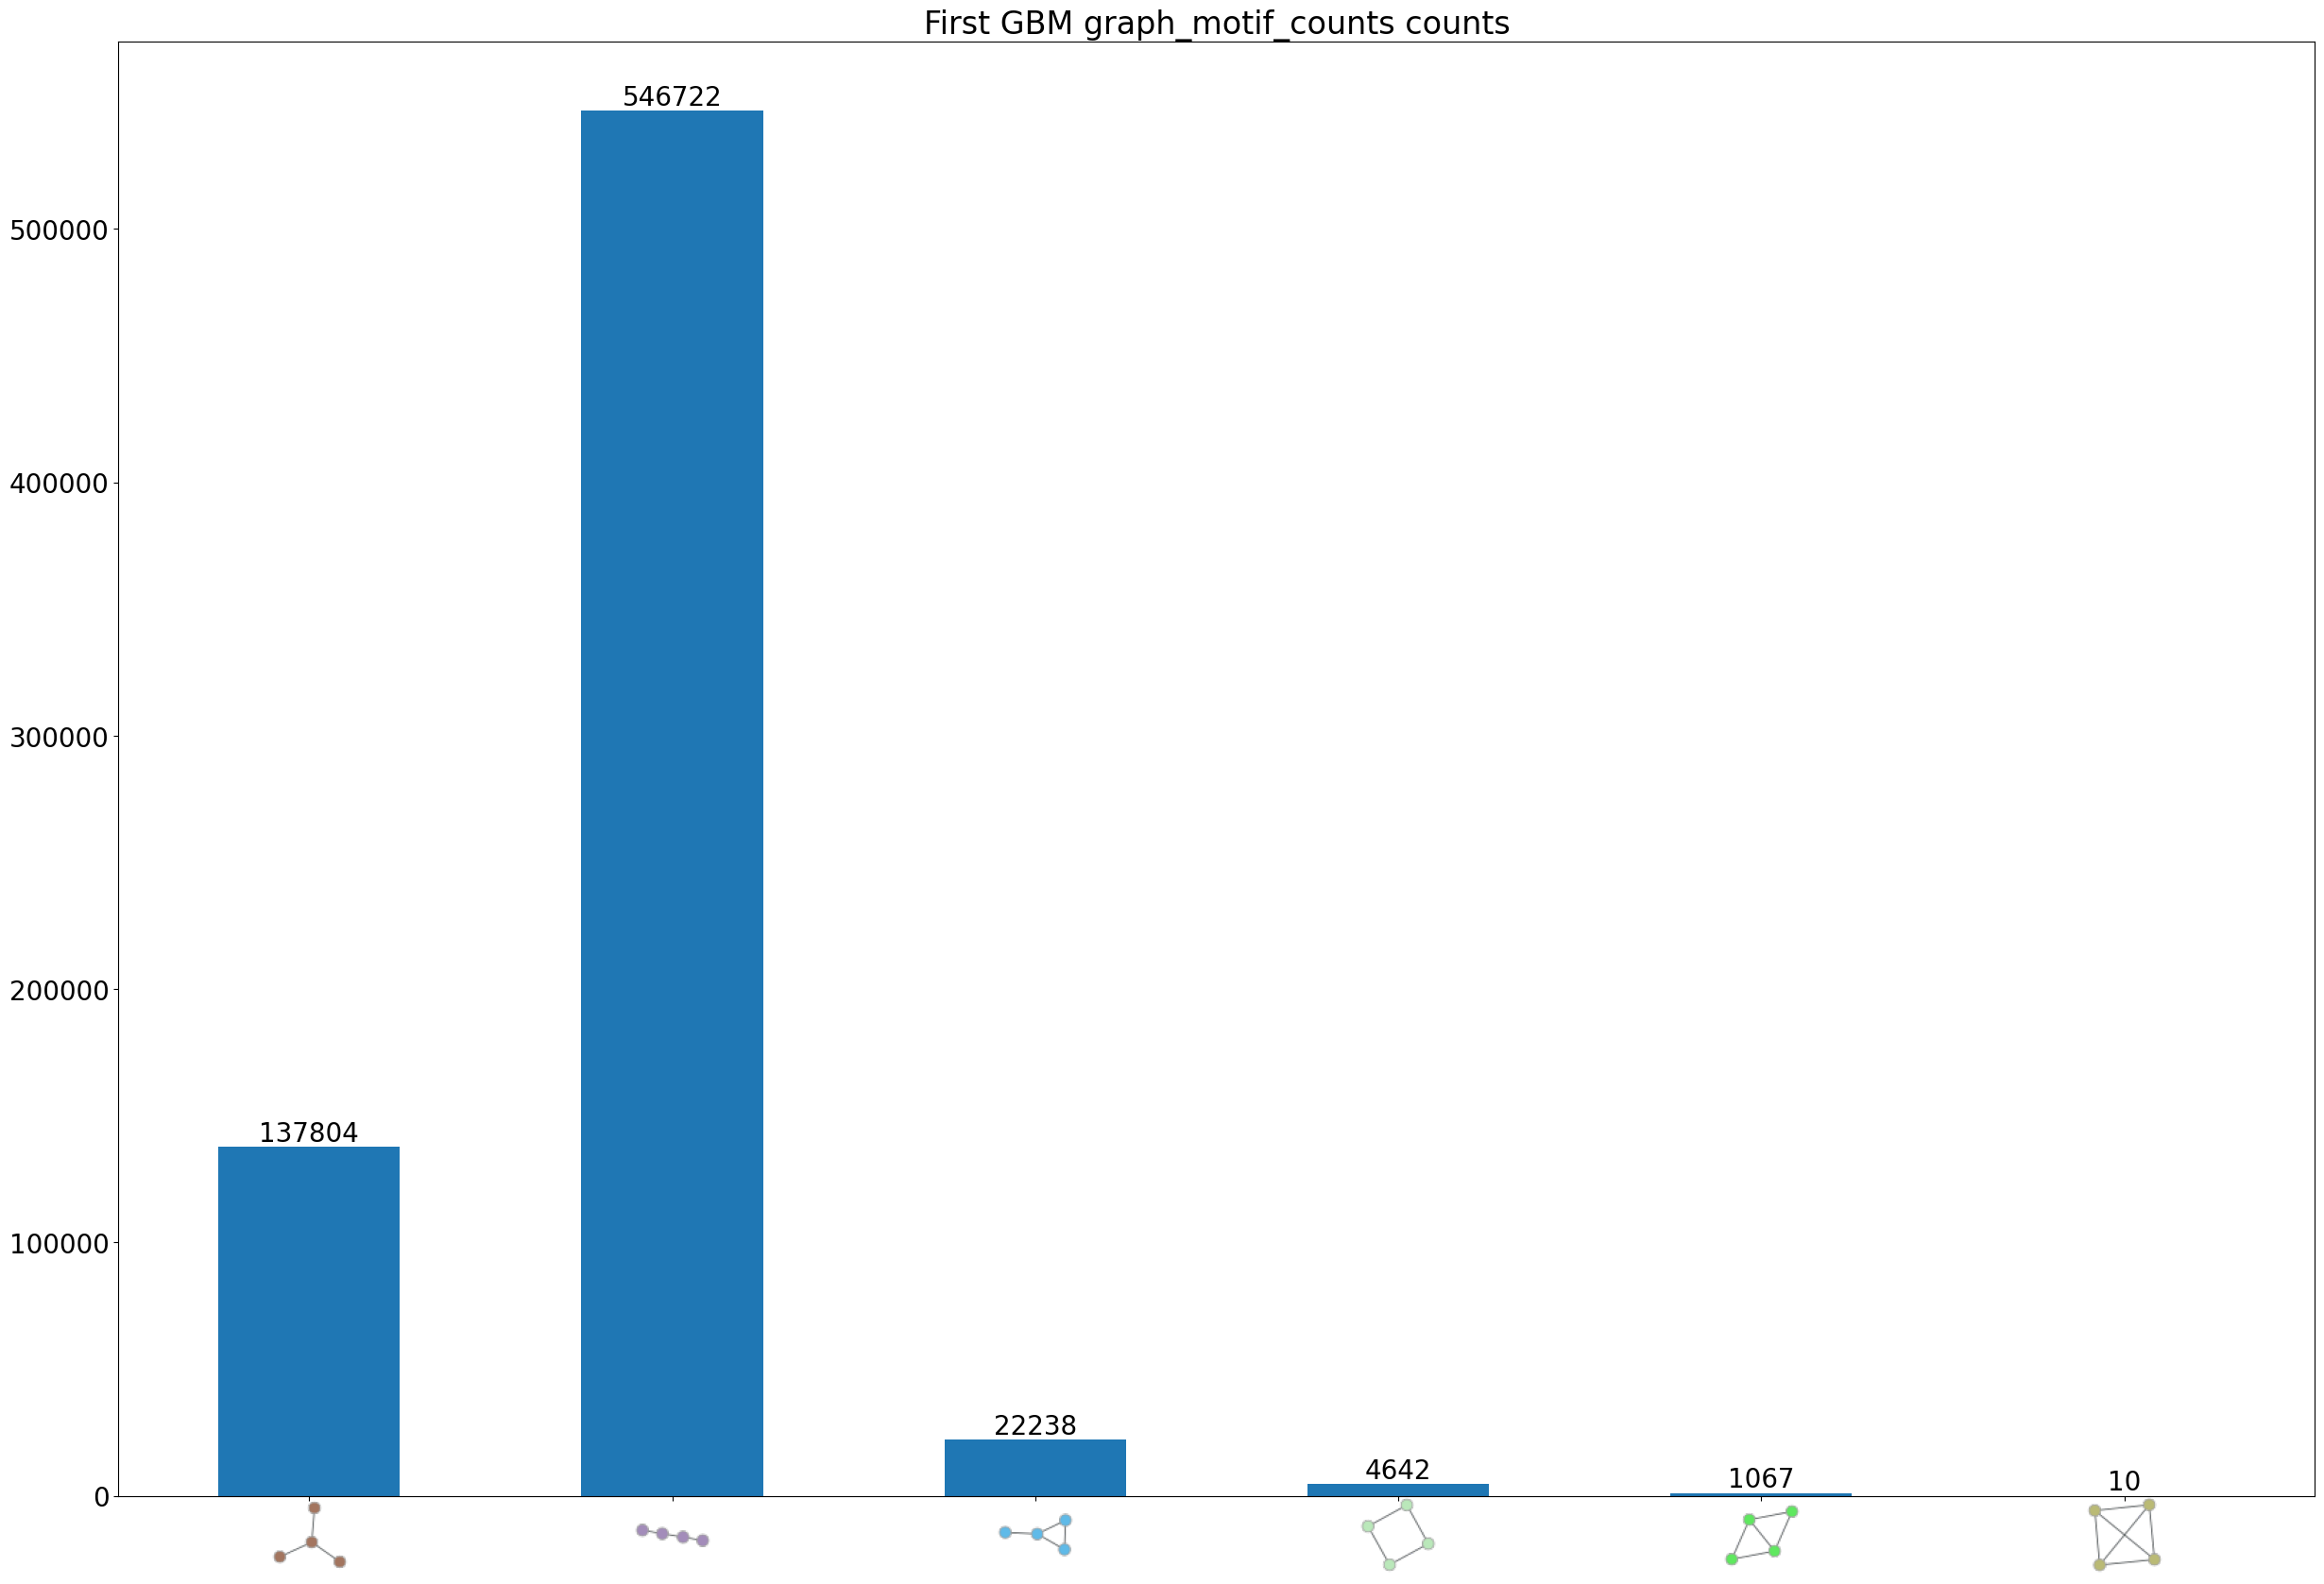

In [27]:
tmp_plot_motif_cnts_per_type(motifs_types=list(motifs_immune_count.keys()), valuesA=_motifs_counts, path_to_save_plot_dir="", subgraph_name="First GBM graph_motif_counts")

### Plot motifs' edges volumes distributions:

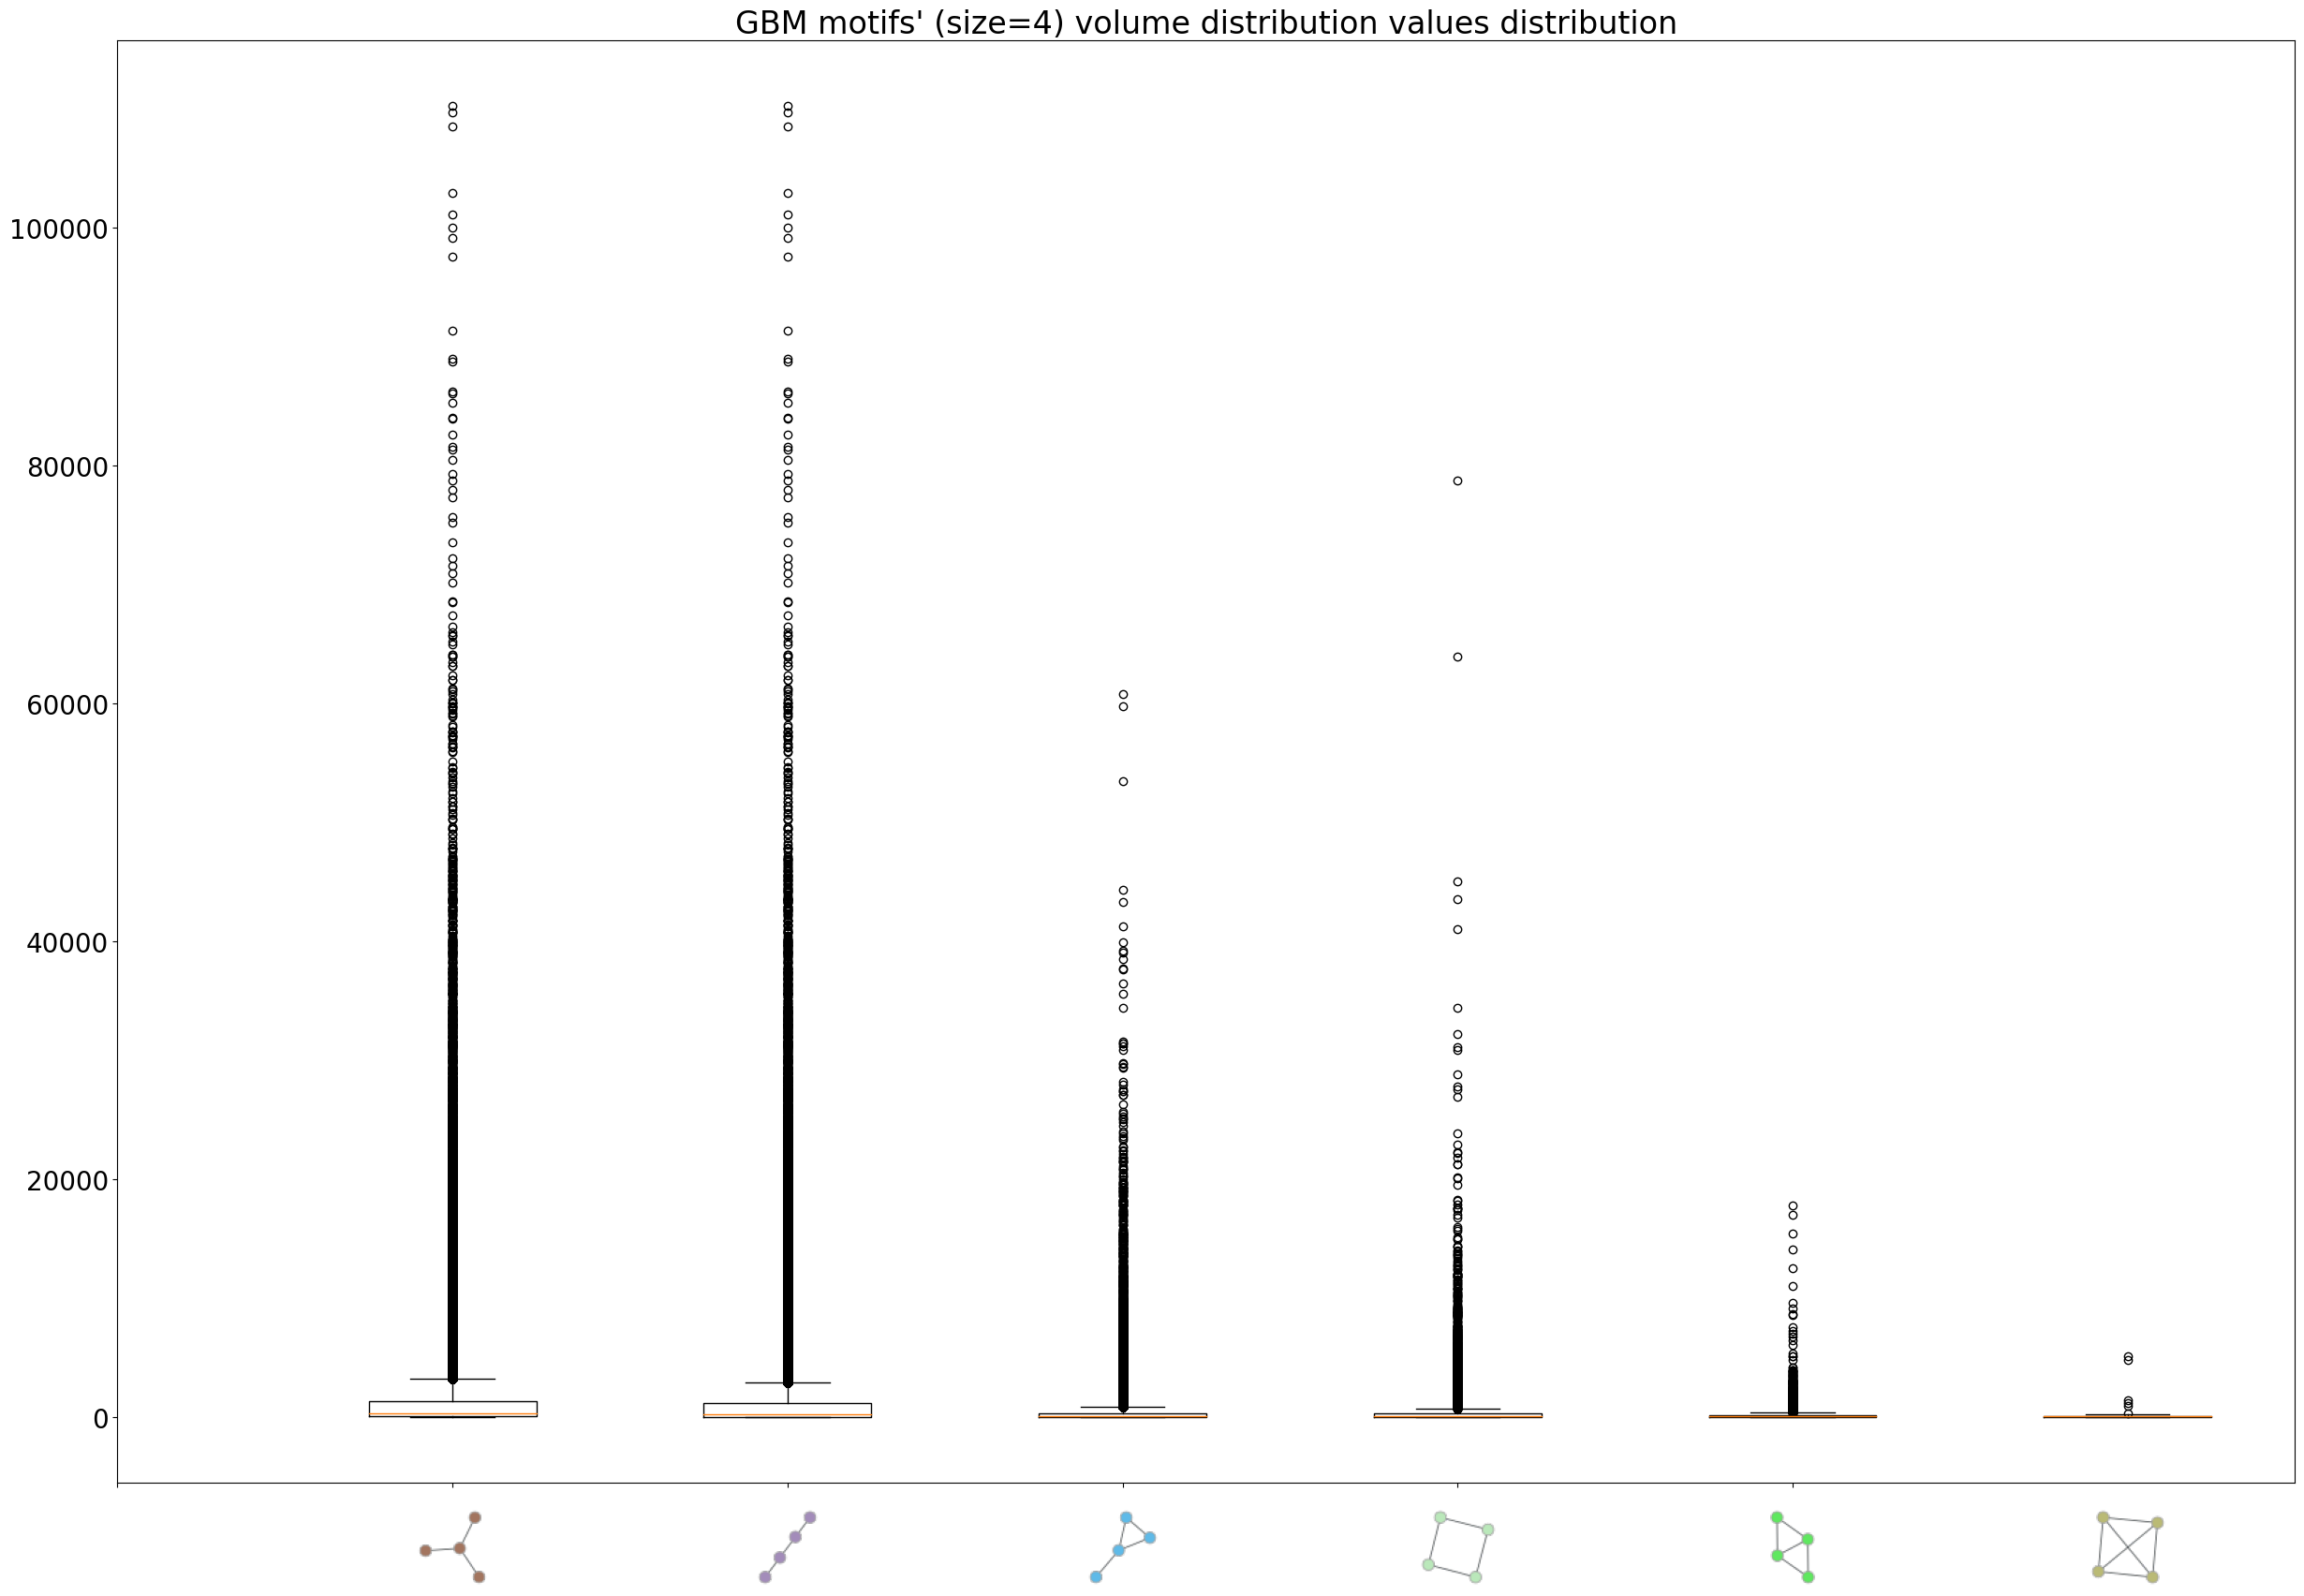

In [28]:
motif_size = 4 if "motif_size" not in locals() else motif_size
tmp_plot_motif_cnts_per_type_as_boxolots(motifs_types=list(motifs_volume_counts.keys()),
                                         valuesA=list(motifs_volume_counts.values()),
                                         subgraph_name=f"GBM motifs' (size={motif_size}) volume distribution",
                                         path_to_save_plot_dir=None,
                                         motifs_len=motif_size,
                                         xybox_for_motifs_illustration=(0, -100))

In [29]:
all_motifs_type_colors

{<Graph object, undirected, with 4 vertices and 3 edges, at 0x1045702b0>: [0.6000000000000001,
  0.4,
  0.3,
  0.9],
 <Graph object, undirected, with 4 vertices and 3 edges, at 0x15cad4490>: [0.6000000000000001,
  0.5,
  0.7000000000000002,
  0.9],
 <Graph object, undirected, with 4 vertices and 4 edges, at 0x15c9b7880>: [0.3,
  0.7000000000000002,
  0.9000000000000001,
  0.9],
 <Graph object, undirected, with 4 vertices and 4 edges, at 0x15c9b6ad0>: [0.7000000000000002,
  0.9000000000000001,
  0.7000000000000002,
  0.9],
 <Graph object, undirected, with 4 vertices and 5 edges, at 0x15c9b7ac0>: [0.3,
  0.9000000000000001,
  0.3,
  0.9],
 <Graph object, undirected, with 4 vertices and 6 edges, at 0x15c9b7310>: [0.7000000000000002,
  0.7000000000000002,
  0.4,
  0.9]}

### Calculate fraction of motifs containing immune cells in edges by motif type

In [18]:
from itertools import combinations, permutations
def get_edge_existing_attribute_fractions_from_motifs_aggregation_from_lst_of_vertices(g: Graph,
                                                                              motifs_vertices_lsts_dict: Dict[Graph, List[List[int]]],
                                                                              #motifs_vertices_lst: List[List[int]] = None,
                                                                               attribute_to_aggregate:Tuple[str, str]=('e', 'artery_binary'),
                                                                               repeat_edge_allowed: bool=False,
                                                                              ):
    n_motifs_instances_with_attribute_num_dict = {}
    n_motifs_instances_without_attribute_num_dict = {}
    for motif_type, motif_type_vertices_lsts in motifs_vertices_lsts_dict.items():
        visited_edges_in_motif_type = set()
        for vertices_lst in motif_type_vertices_lsts: # iterate each detected motif of the type vertices list (the vertices of the specific instance of the motif)
            # create the possible edges in the motif:
            possible_edges = combinations(vertices_lst.a, 2)
            possible_edges = list(possible_edges)
            # filter the edges not really in the graph, hence not in the motif:
            existing_edges_in_motif = map(lambda vertices: g.edge(vertices[0], vertices[1]), list(filter(lambda vertices: g.edge(vertices[0], vertices[1]) is not None, possible_edges)))
            found_in_motif = False
            for edge in existing_edges_in_motif: # iterate over all edges in the motif instance
                if not repeat_edge_allowed and edge in visited_edges_in_motif_type: # repeats allowed in motif type?
                    visited_edges_in_motif_type.update({edge})
                    continue
                # check if the edge contains the target attribute (i.e. not zero)
                is_edge_with_attribute = bool(g.properties[attribute_to_aggregate][edge])
                if is_edge_with_attribute:
                    n_motifs_instances_with_attribute_num_dict[motif_type] = n_motifs_instances_with_attribute_num_dict.get(motif_type, 0) + 1
                    found_in_motif = True # if found in a single edge, move to next motif instance
                    break
            # if not found in any edge of the motif instance, update motifs instances without attribute counter
            if not found_in_motif:
                n_motifs_instances_without_attribute_num_dict[motif_type] = n_motifs_instances_without_attribute_num_dict.get(motif_type, 0) + 1
    motifs_with_attribute_fractions_dict = {_motif_type: n_motifs_instances_with_attribute_num_dict.get(_motif_type, 0)/
                                            (n_motifs_instances_with_attribute_num_dict.get(_motif_type, 0) + n_motifs_instances_without_attribute_num_dict.get(_motif_type, 0))
                                            for _motif_type in set(list(n_motifs_instances_with_attribute_num_dict.keys()) + list(n_motifs_instances_without_attribute_num_dict.keys()))}
    return motifs_with_attribute_fractions_dict

In [19]:
motifs_vertices_lsts_dict = {
    _motifs[motif_idx]: motifs_vertex_properties[motif_idx] for motif_idx in range(len(_motifs))}

In [20]:
motifs_instances_fraction_with_attributes_repeat_edges_allowed = get_edge_existing_attribute_fractions_from_motifs_aggregation_from_lst_of_vertices(
        g=g,
        motifs_vertices_lsts_dict=motifs_vertices_lsts_dict,
        repeat_edge_allowed=True
    )
motifs_instances_fraction_with_attributes_repeat_edges_not_allowed = get_edge_existing_attribute_fractions_from_motifs_aggregation_from_lst_of_vertices(
    g=g,
    motifs_vertices_lsts_dict=motifs_vertices_lsts_dict,
    repeat_edge_allowed=False
)

### Plot fraction of motifs containing immune cells in edges by motif type

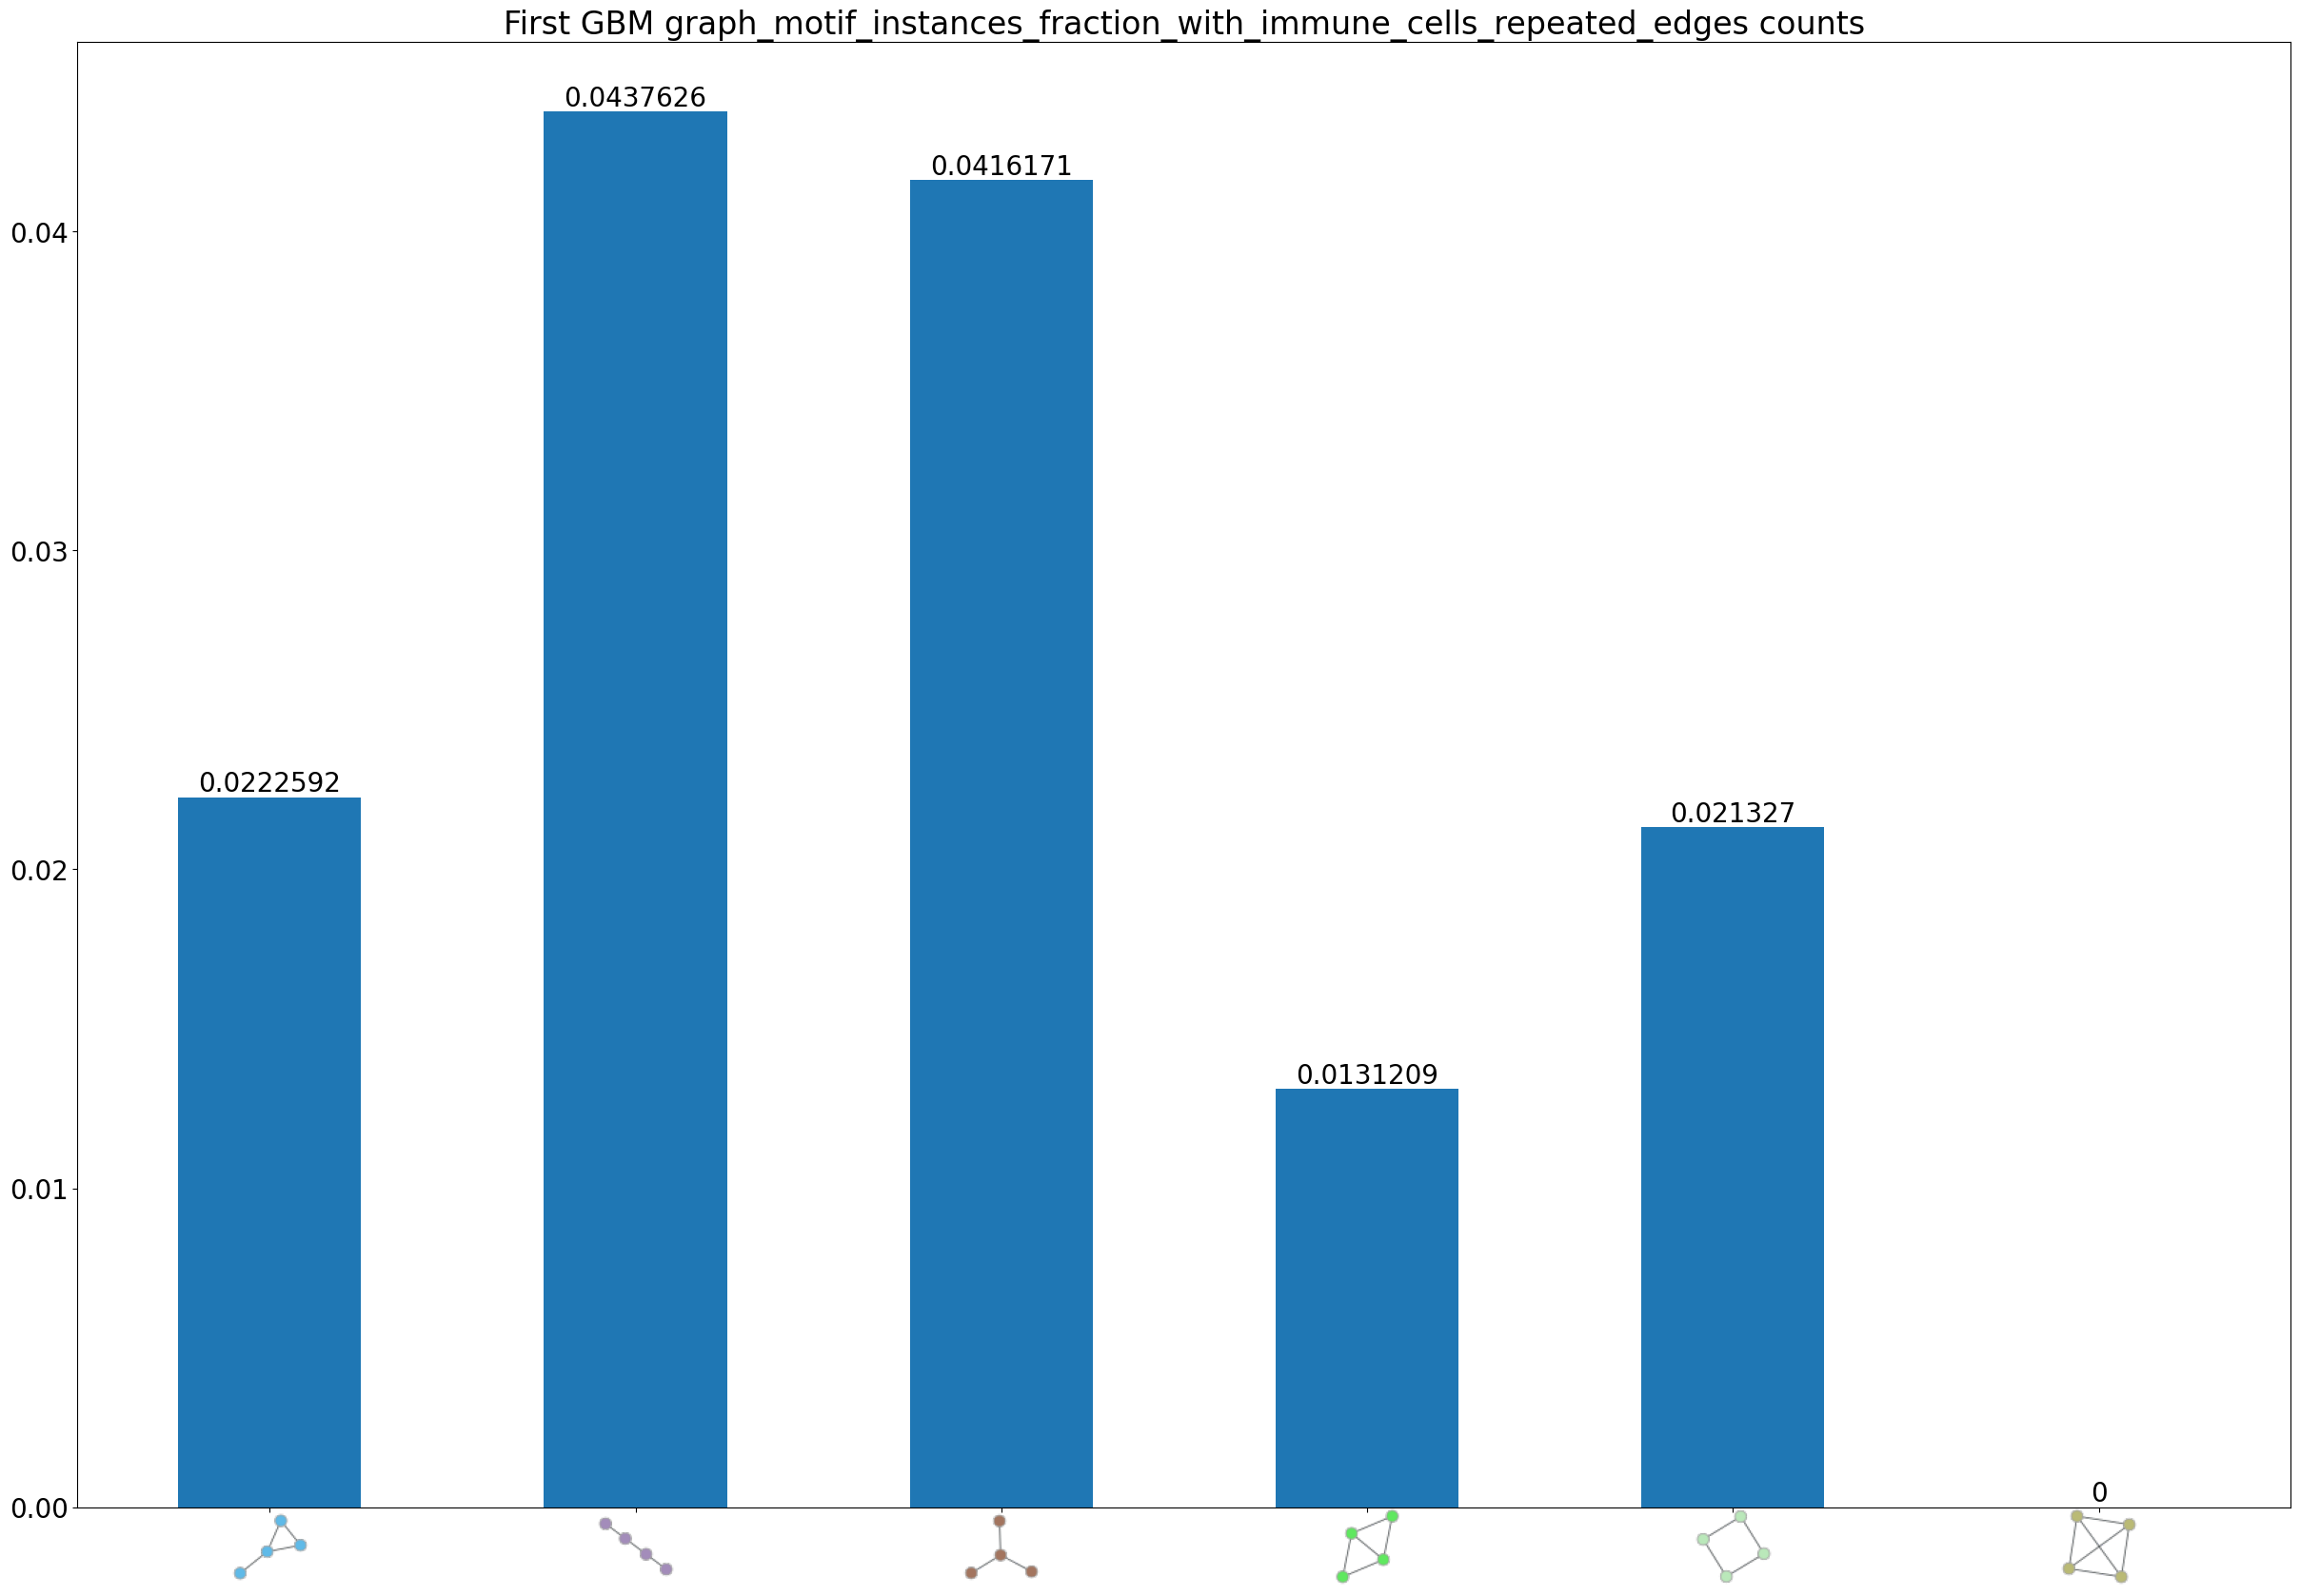

In [33]:
plot_motif_cnts_per_type(motifs_types=list(motifs_instances_fraction_with_attributes_repeat_edges_allowed.keys()), valuesA=list(motifs_instances_fraction_with_attributes_repeat_edges_allowed.values()), path_to_save_plot_dir="", subgraph_name="First GBM graph_motif_instances_fraction_with_immune_cells_repeated_edges")

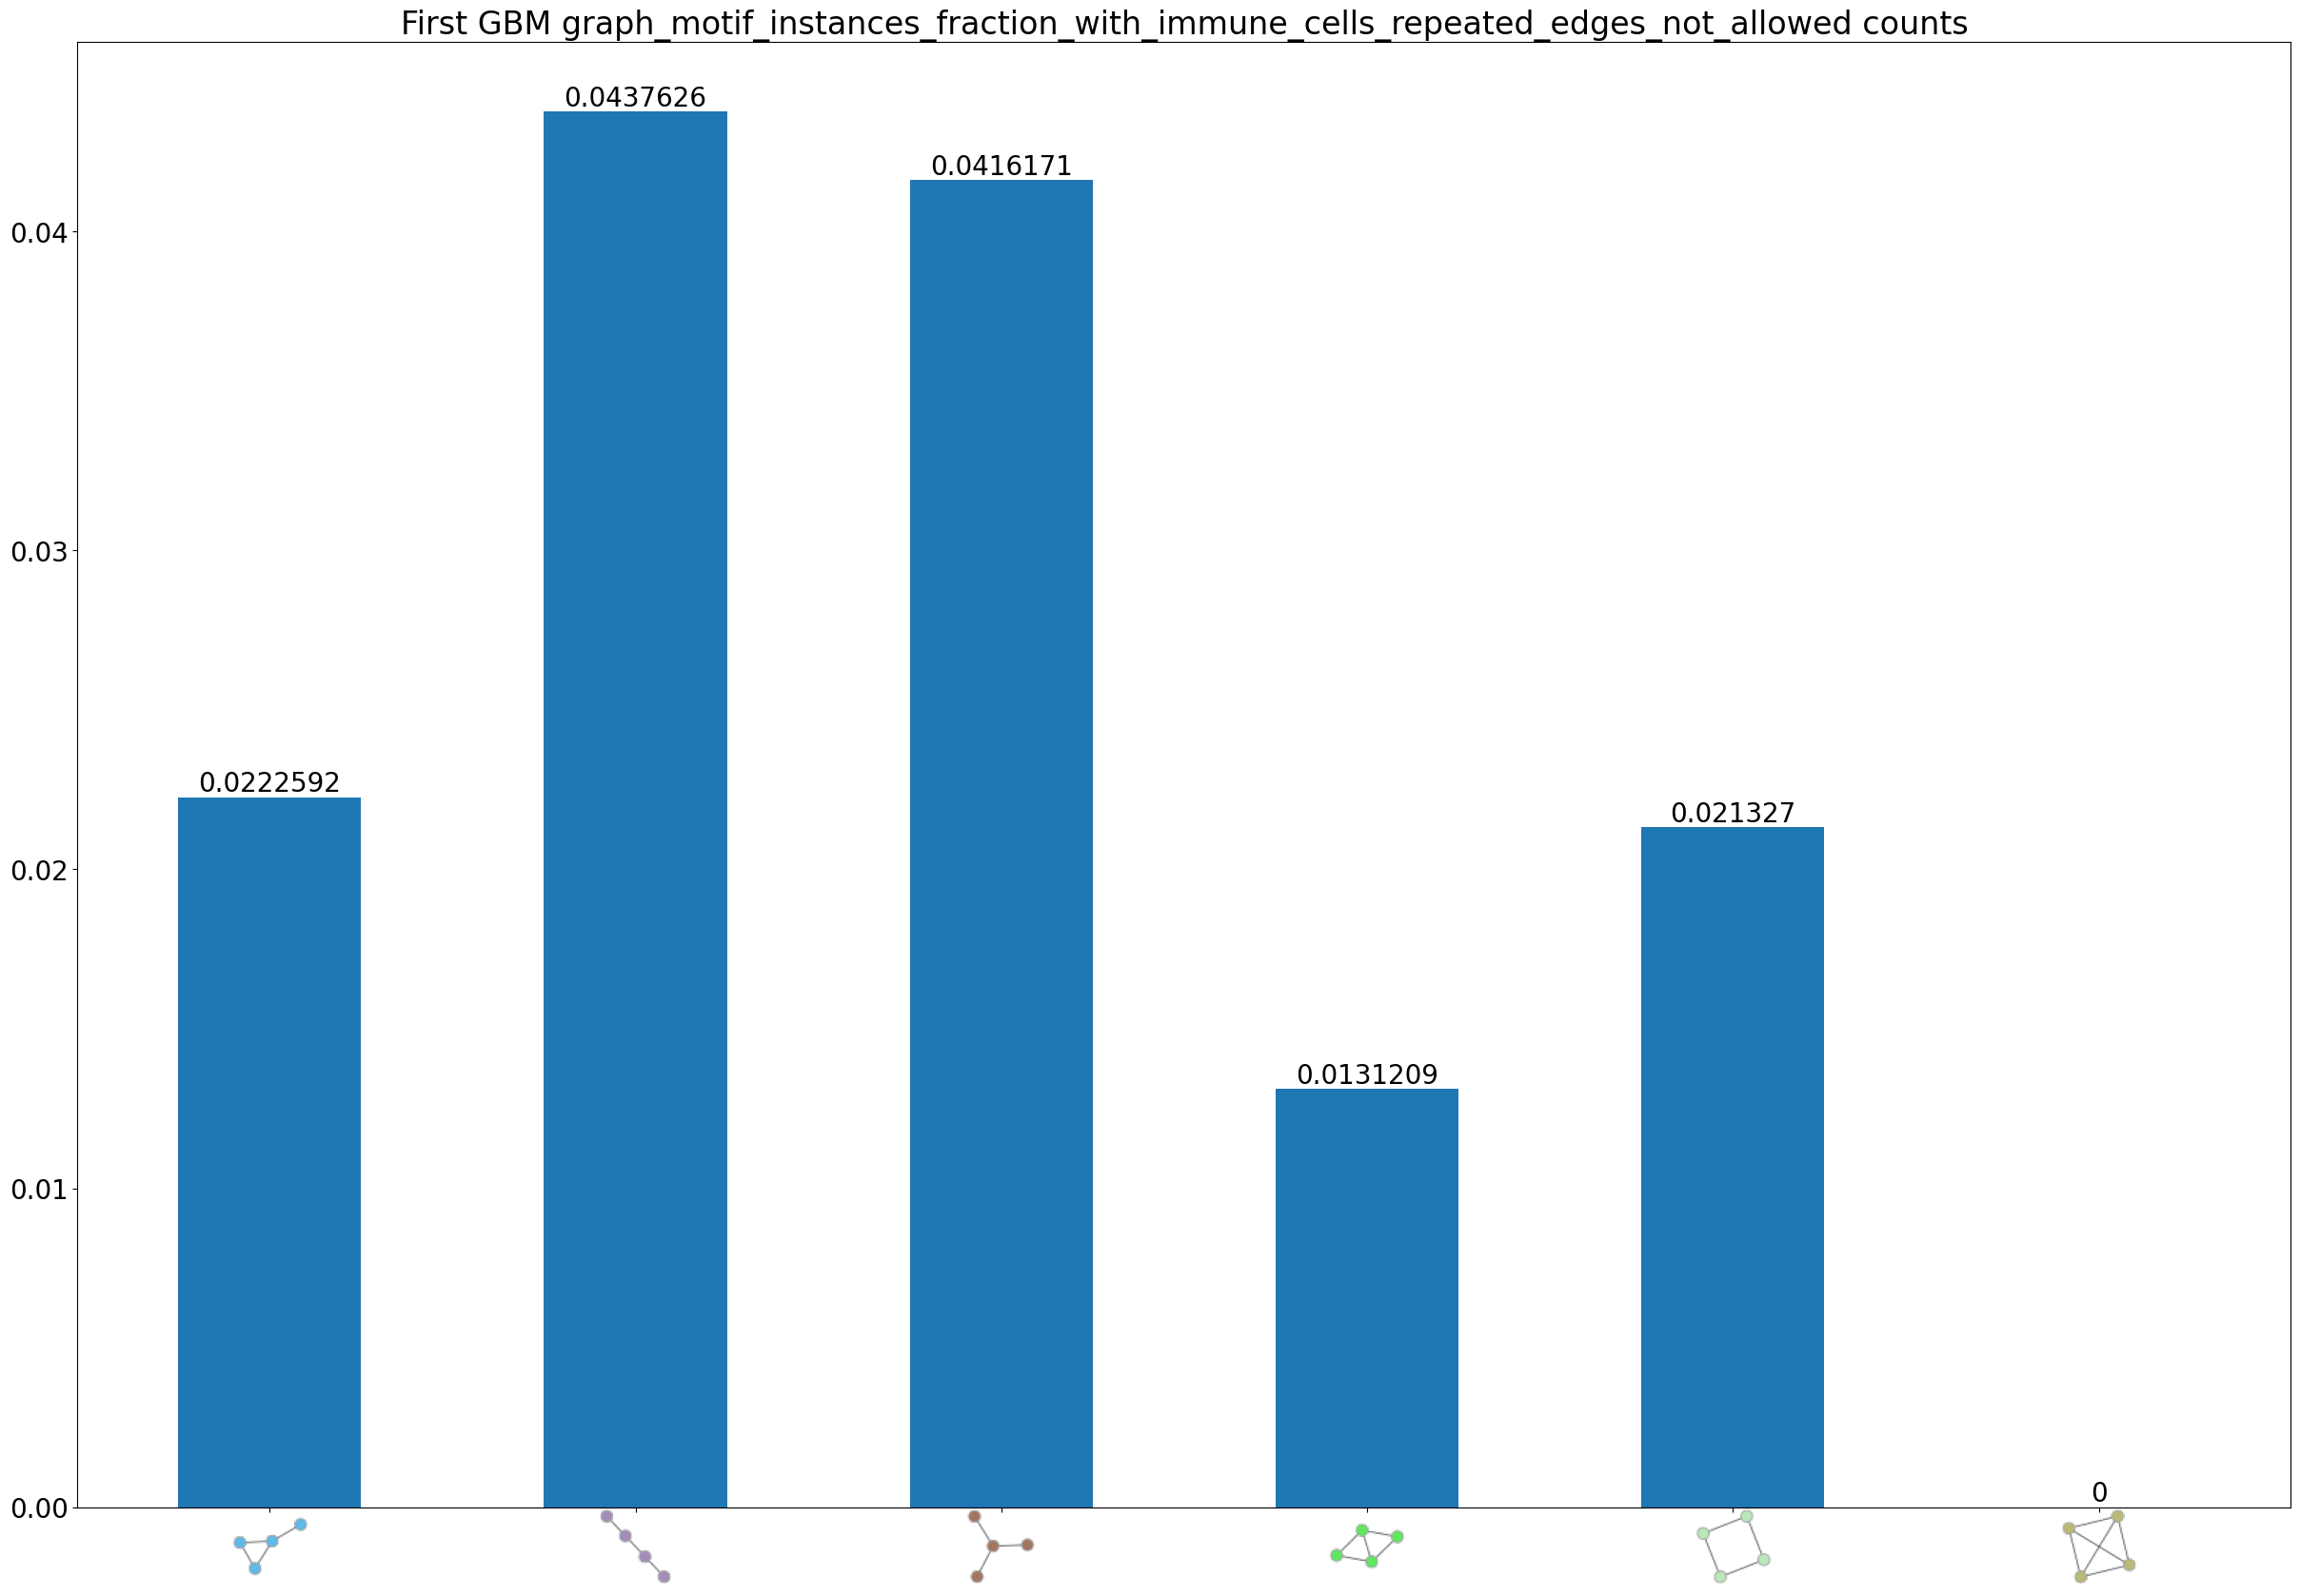

In [34]:
plot_motif_cnts_per_type(motifs_types=list(motifs_instances_fraction_with_attributes_repeat_edges_not_allowed.keys()), valuesA=list(motifs_instances_fraction_with_attributes_repeat_edges_not_allowed.values()), path_to_save_plot_dir="", subgraph_name="First GBM graph_motif_instances_fraction_with_immune_cells_repeated_edges_not_allowed")

### Calculate motifs instances fraction of edges containing immune cells by motif type

In [20]:
def get_edge_existing_attribute_motifs_instances_mean_and_std_fraction_of_edges_with_attributes(g: Graph,
                                                                                  motifs_vertices_lsts_dict: Dict[Graph, List[List[int]]],         attribute_to_aggregate:Tuple[str, str]=('e', 'artery_binary'),                                include_in_calc_0_containing_edges_instances: bool = True):
    motifs_instances_fraction_of_edges_with_attribute_by_motif_type_dict = {}
    for motif_type, motif_type_vertices_lsts in motifs_vertices_lsts_dict.items():
        visited_edges_in_motif_type = set()
        for vertices_lst in motif_type_vertices_lsts: # iterate each detected motif of the type vertices list (the vertices of the specific instance of the motif)
            motif_instance_num_of_edges_containing_attribute = 0
            # create the possible edges in the motif:
            possible_edges = combinations(vertices_lst.a, 2)
            possible_edges = list(possible_edges)
            # filter the edges not really in the graph, hence not in the motif:
            existing_edges_in_motif = list(map(lambda vertices: g.edge(vertices[0], vertices[1]), list(filter(lambda vertices: g.edge(vertices[0], vertices[1]) is not None, possible_edges))))
            for edge in existing_edges_in_motif: # iterate over all edges in the motif instance
                # check if the edge contains the target attribute (i.e. not zero)
                is_edge_with_attribute = bool(g.properties[attribute_to_aggregate][edge])
                if is_edge_with_attribute:
                    motif_instance_num_of_edges_containing_attribute+=1

            motifs_instances_fraction_of_edges_with_attribute_by_motif_type_dict[motif_type] = motifs_instances_fraction_of_edges_with_attribute_by_motif_type_dict.get(motif_type, []) + [motif_instance_num_of_edges_containing_attribute/len(existing_edges_in_motif)]

    if include_in_calc_0_containing_edges_instances:
        _motif_type_instances_mean_fraction_of_edges_containing_attribute = {_motif_type: np.mean(_motif_type_instances_fractions_of_edges_containing_attribute)
                                                for _motif_type, _motif_type_instances_fractions_of_edges_containing_attribute in motifs_instances_fraction_of_edges_with_attribute_by_motif_type_dict.items()}

        _motif_type_instances_std_fraction_of_edges_containing_attribute = {_motif_type: np.std(_motif_type_instances_fractions_of_edges_containing_attribute)
                                                for _motif_type, _motif_type_instances_fractions_of_edges_containing_attribute in motifs_instances_fraction_of_edges_with_attribute_by_motif_type_dict.items()},
    else:
        _motif_type_instances_mean_fraction_of_edges_containing_attribute = {_motif_type: np.mean(list(filter(lambda x: x!=0,   _motif_type_instances_fractions_of_edges_containing_attribute))) for _motif_type, _motif_type_instances_fractions_of_edges_containing_attribute in motifs_instances_fraction_of_edges_with_attribute_by_motif_type_dict.items()}

        _motif_type_instances_std_fraction_of_edges_containing_attribute = {_motif_type: np.std(list(filter(lambda x: x!=0, _motif_type_instances_fractions_of_edges_containing_attribute)))
                                                for _motif_type, _motif_type_instances_fractions_of_edges_containing_attribute in motifs_instances_fraction_of_edges_with_attribute_by_motif_type_dict.items()}

    return _motif_type_instances_mean_fraction_of_edges_containing_attribute, _motif_type_instances_std_fraction_of_edges_containing_attribute,

def get_edge_existing_attribute_motifs_instances_mean_and_std_of_edges_attribute_values(g: Graph,
                                                                          motifs_vertices_lsts_dict: Dict[Graph, List[List[int]]],
                                                                           attribute_to_aggregate:Tuple[str, str]=('e', 'artery_binary'),
                                                                                            include_in_calc_0_containing_edges_instances: bool = True, include_only_edges_with_immune_cells: bool=False,
                                                                          ):

    # todo: refactor to use get_edge_attribute_values_aggregation_from_lst_of_vertices method,
    motifs_instances_edges_attribute_values_with_attribute_by_motif_type_dict = {},
    for motif_type, motif_type_vertices_lsts in motifs_vertices_lsts_dict.items():
        for vertices_lst in motif_type_vertices_lsts: # iterate each detected motif of the type vertices list (the vertices of the specific instance of the motif),
            # create the possible edges in the motif:
            possible_edges = combinations(vertices_lst.a, 2),
            possible_edges = list(possible_edges),
            # filter the edges not really in the graph, hence not in the motif:
            existing_edges_in_motif = list(map(lambda vertices: g.edge(vertices[0], vertices[1]), list(filter(lambda vertices: g.edge(vertices[0], vertices[1]) is not None, possible_edges))))
            if include_only_edges_with_immune_cells:
                # filter all edges with no immune cells,
                existing_edges_in_motif = list(filter(lambda edge: g.properties[('e', 'artery_binary')][edge], existing_edges_in_motif))
            edges_values_lst = [g.properties[attribute_to_aggregate][edge] for edge in existing_edges_in_motif]
            motifs_instances_edges_attribute_values_with_attribute_by_motif_type_dict[motif_type] = motifs_instances_edges_attribute_values_with_attribute_by_motif_type_dict.get(motif_type, []) + edges_values_lst

    if  include_in_calc_0_containing_edges_instances:
        _motif_type_instances_mean_edges_attribute_values_containing_attribute = {_motif_type: np.mean(_motif_type_instances_fractions_of_edges_containing_attribute)
                                                for _motif_type, _motif_type_instances_fractions_of_edges_containing_attribute in motifs_instances_edges_attribute_values_with_attribute_by_motif_type_dict.items()}

        _motif_type_instances_std_edges_attribute_values_containing_attribute = {_motif_type: np.std(_motif_type_instances_fractions_of_edges_containing_attribute)
                                                for _motif_type, _motif_type_instances_fractions_of_edges_containing_attribute in motifs_instances_edges_attribute_values_with_attribute_by_motif_type_dict.items()}
    else:
        _motif_type_instances_mean_edges_attribute_values_containing_attribute = {_motif_type: np.mean(list(filter(lambda x: x!=0, _motif_type_instances_fractions_of_edges_containing_attribute)))
                                                for _motif_type, _motif_type_instances_fractions_of_edges_containing_attribute in motifs_instances_edges_attribute_values_with_attribute_by_motif_type_dict.items()}

        _motif_type_instances_std_edges_attribute_values_containing_attribute = {_motif_type: np.std(list(filter(lambda x: x!=0, _motif_type_instances_fractions_of_edges_containing_attribute)))
                                                for _motif_type, _motif_type_instances_fractions_of_edges_containing_attribute in motifs_instances_edges_attribute_values_with_attribute_by_motif_type_dict.items()}

    return _motif_type_instances_mean_edges_attribute_values_containing_attribute, _motif_type_instances_std_edges_attribute_values_containing_attribute

In [36]:
motifs_instances_mean_fraction_of_edges_with_attributes, motifs_instances_std_fraction_of_edges_with_attributes = get_edge_existing_attribute_motifs_instances_mean_and_std_fraction_of_edges_with_attributes(
        g=g,
        motifs_vertices_lsts_dict=motifs_vertices_lsts_dict,
    )

### Plot mean fraction of motifs instances edges containing immune cells by motif type

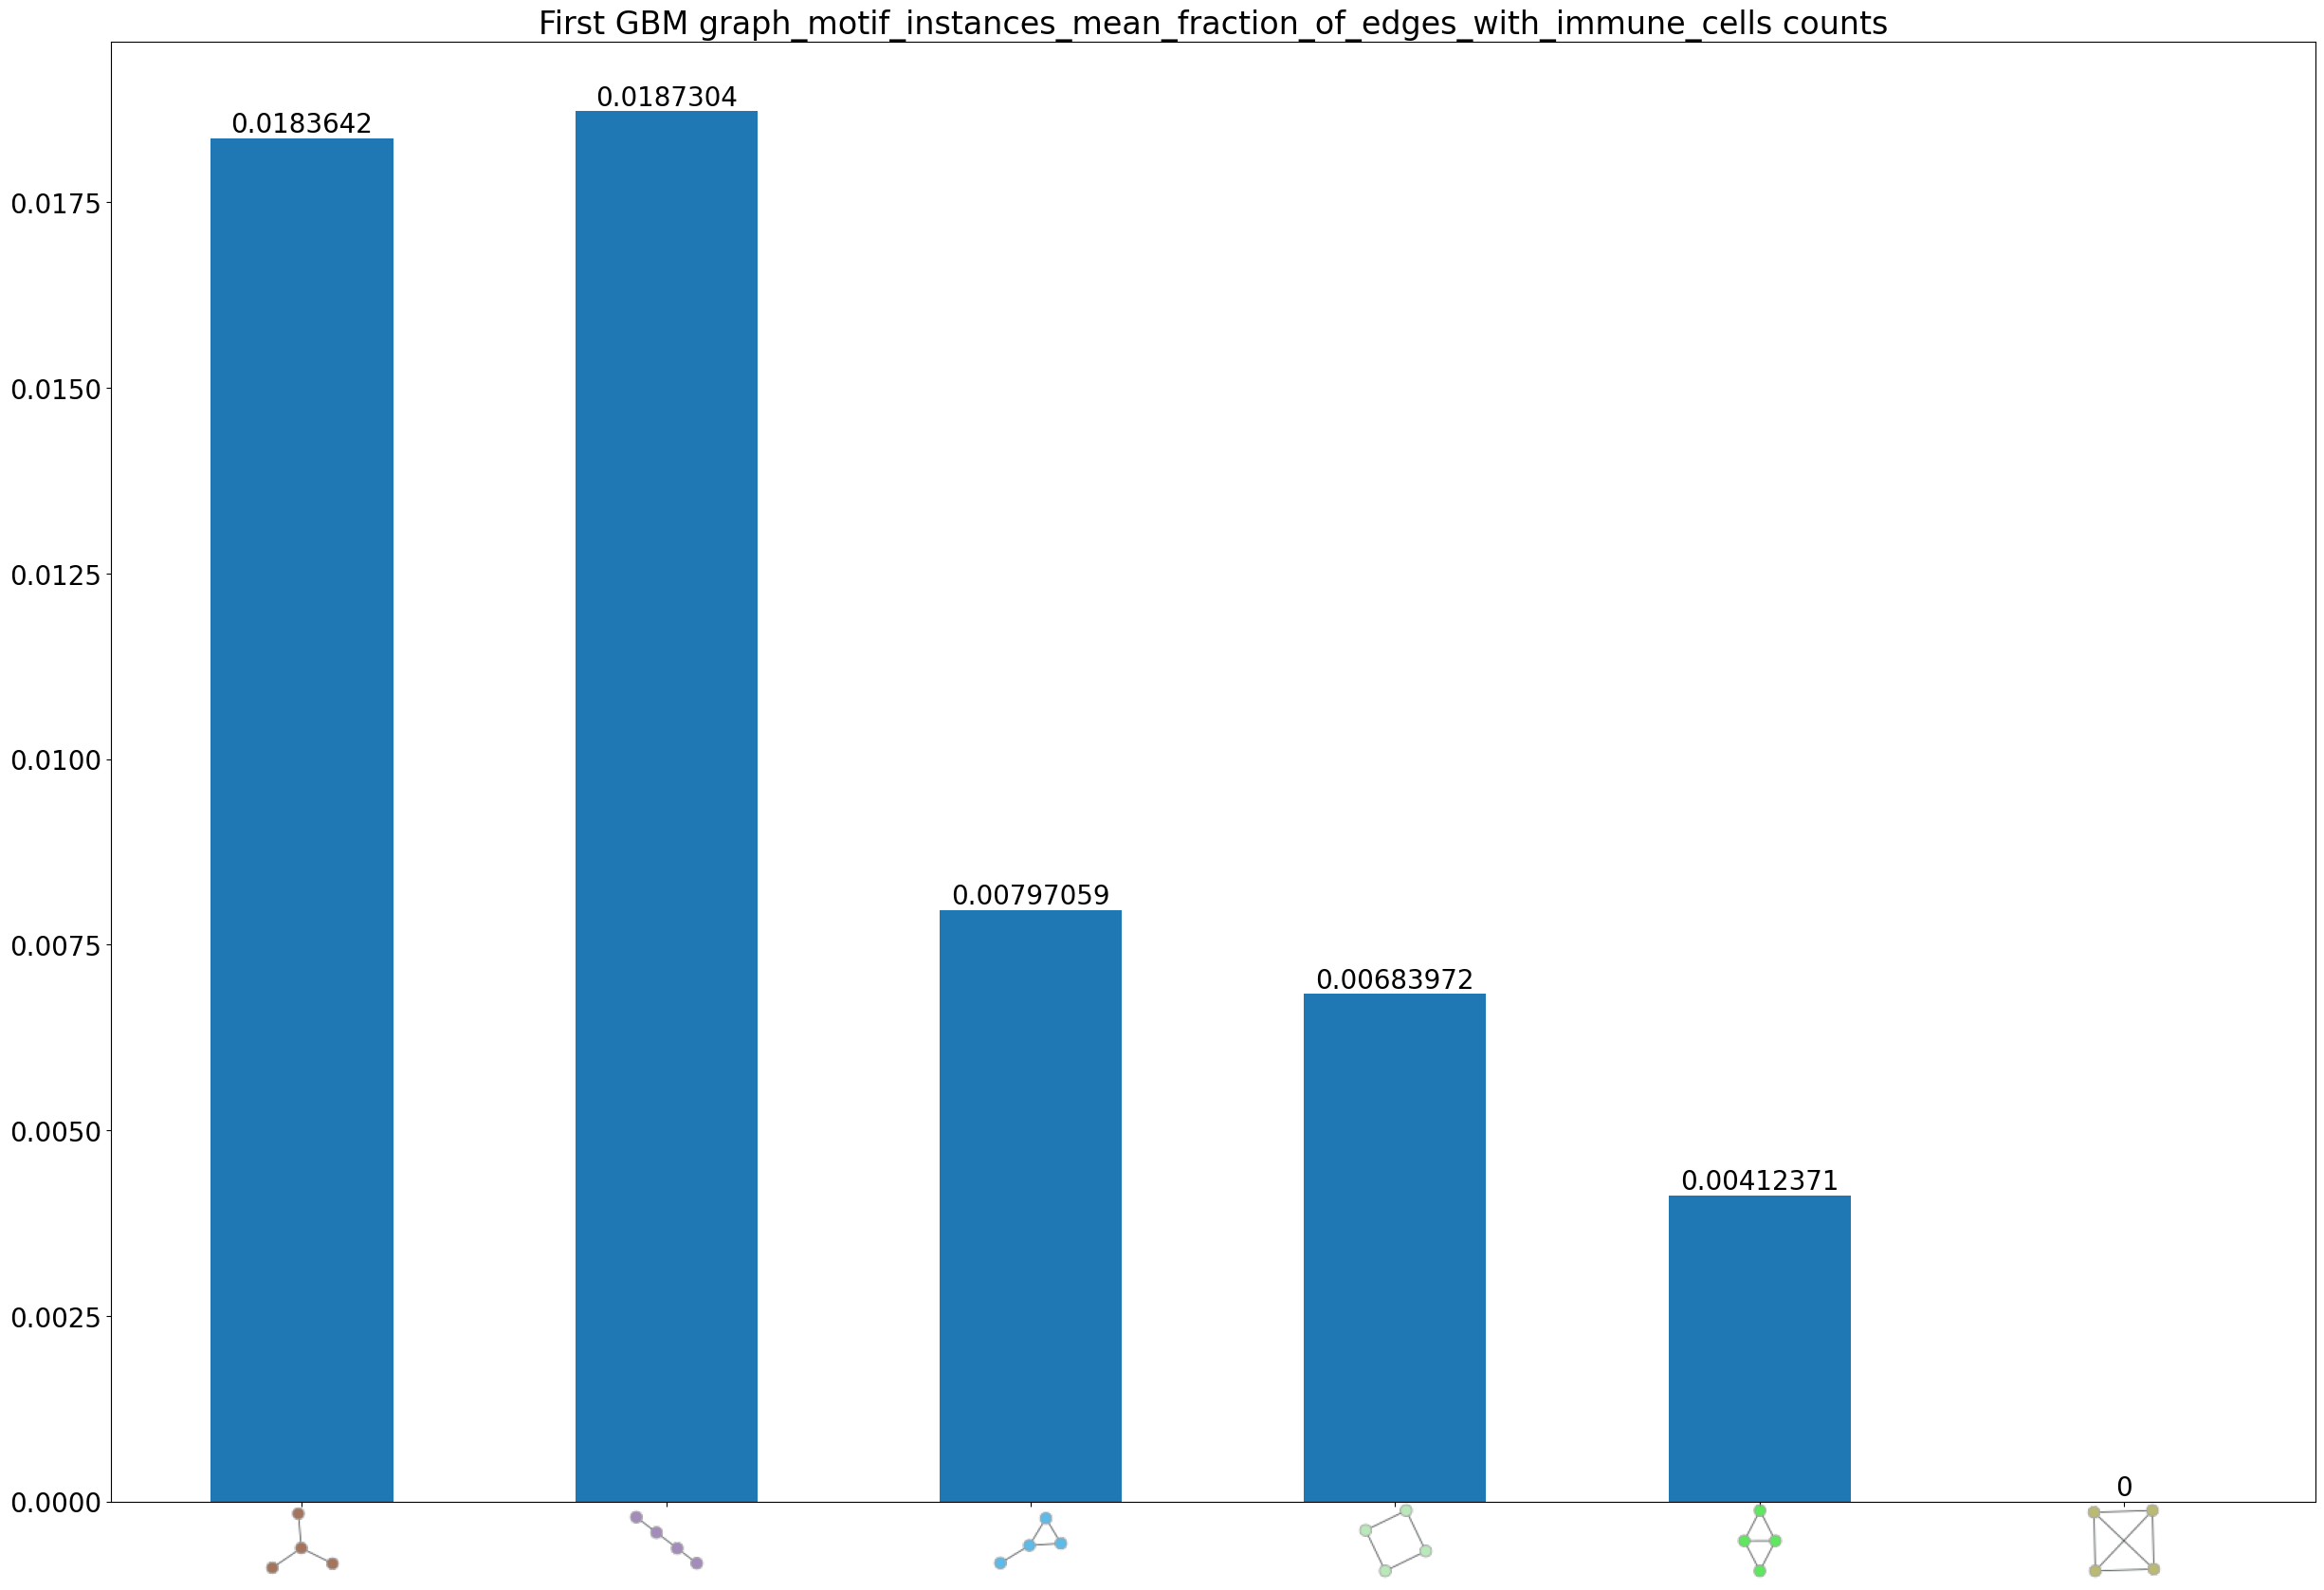

In [37]:
plot_motif_cnts_per_type(motifs_types=list(motifs_instances_mean_fraction_of_edges_with_attributes.keys()), valuesA=list(motifs_instances_mean_fraction_of_edges_with_attributes.values()), path_to_save_plot_dir="", subgraph_name="First GBM graph_motif_instances_mean_fraction_of_edges_with_immune_cells")

### Plot std fraction of motifs instances edges containing immune cells in edges by motif type

In [40]:
motifs_instances_std_fraction_of_edges_with_attributes = motifs_instances_std_fraction_of_edges_with_attributes[0]

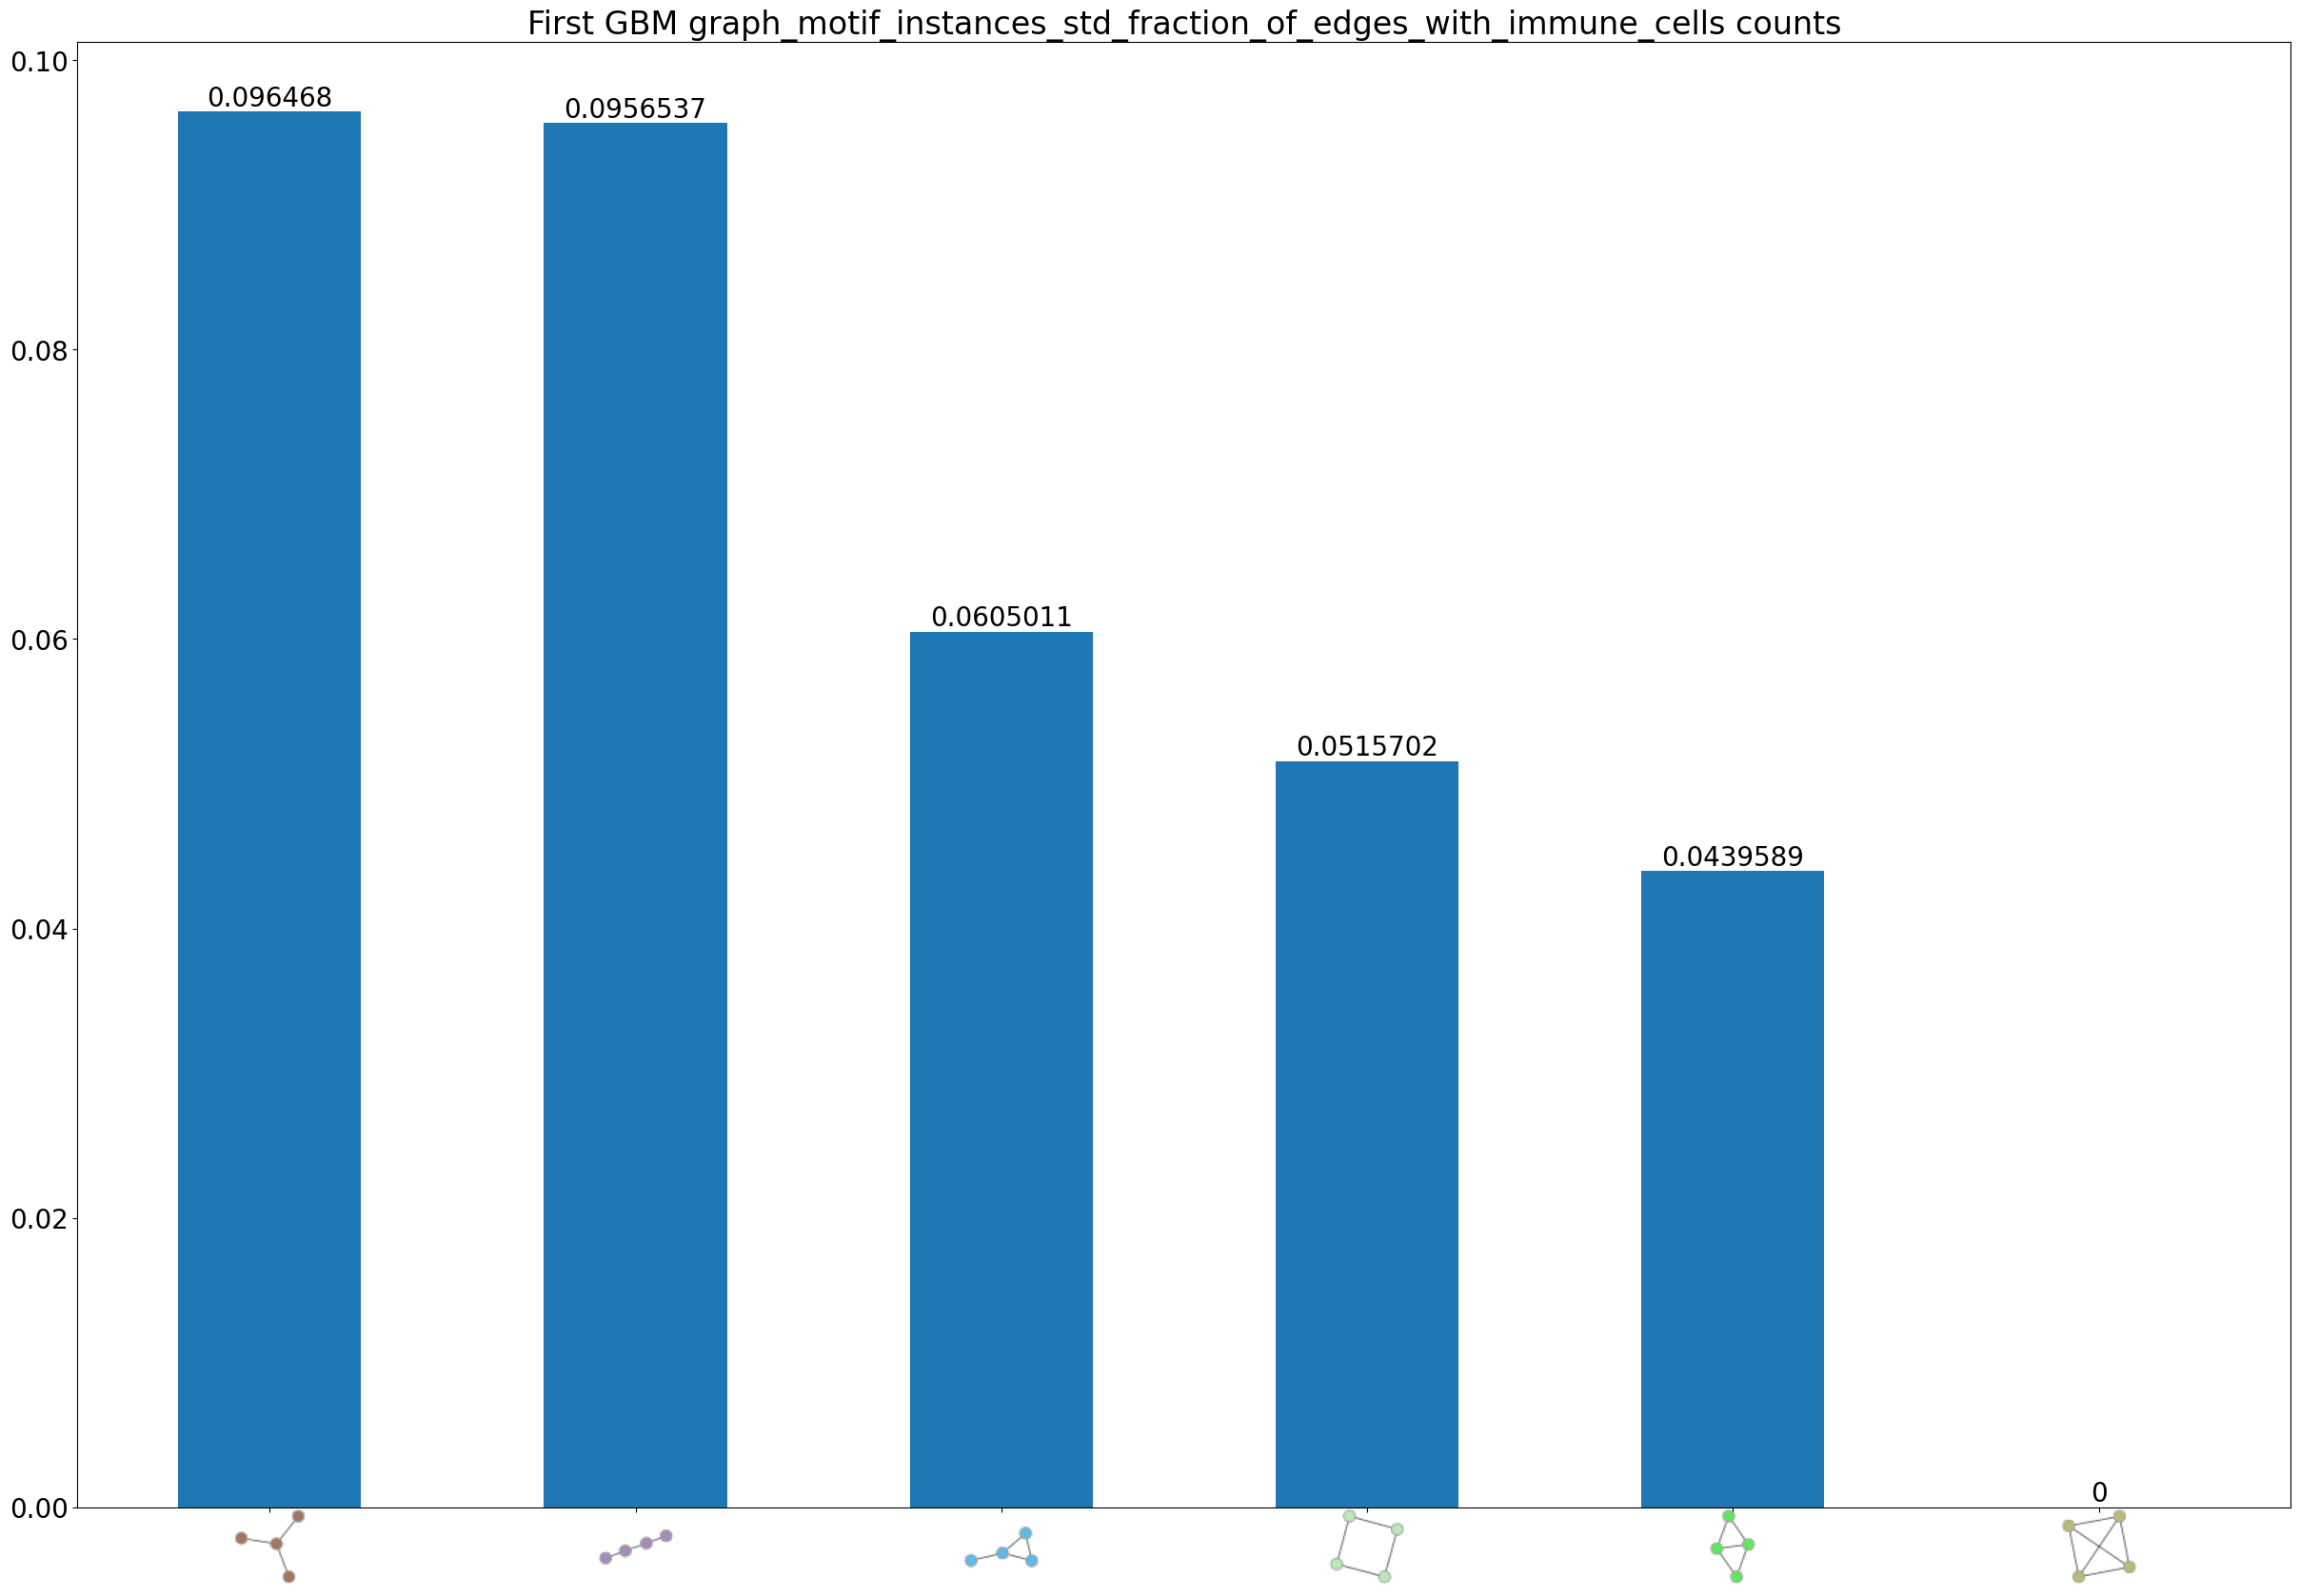

In [41]:
plot_motif_cnts_per_type(motifs_types=list(motifs_instances_std_fraction_of_edges_with_attributes.keys()), valuesA=list(motifs_instances_std_fraction_of_edges_with_attributes.values()), path_to_save_plot_dir="", subgraph_name="First GBM graph_motif_instances_std_fraction_of_edges_with_immune_cells")

### Calculate mean & std fraction of motifs instances edges containing immune cells in edges by motif type excluding empty instances (motif instances with no immune cells)

In [42]:
motifs_instances_mean_fraction_of_edges_with_attributes_no_empty_instances, motifs_instances_std_fraction_of_edges_with_attributes_no_empty_instances = get_edge_existing_attribute_motifs_instances_mean_and_std_fraction_of_edges_with_attributes(
    g=g,
    motifs_vertices_lsts_dict=motifs_vertices_lsts_dict,
    include_in_calc_0_containing_edges_instances = False
)

KeyboardInterrupt: 

### Plot mean fraction of motifs instances edges containing immune cells in edges by motif type excluding empty instances (motif instances with no immune cells)

In [ ]:
plot_motif_cnts_per_type(motifs_types=list(motifs_instances_mean_fraction_of_edges_with_attributes_no_empty_instances.keys()), valuesA=list(motifs_instances_mean_fraction_of_edges_with_attributes_no_empty_instances.values()), path_to_save_plot_dir="", subgraph_name="First GBM graph_motif_instances_mean_fraction_of_edges_with_immune_cells_no_empty_instances")

### Plot std fraction of motifs instances edges containing immune cells in edges by motif type excluding empty instances (motif instances with no immune cells)

In [ ]:
plot_motif_cnts_per_type(motifs_types=list(motifs_instances_std_fraction_of_edges_with_attributes_no_empty_instances.keys()), valuesA=list(motifs_instances_std_fraction_of_edges_with_attributes_no_empty_instances.values()), path_to_save_plot_dir="", subgraph_name="First GBM graph_motif_instances_std_fraction_of_edges_with_immune_cells_no_empty_instances")

### Calculate motifs instances mean + std fraction of edges lengths by motif type

#### including edges with no immune cells

In [ ]:
motifs_instances_mean_edges_attribute_values_with_attributes, motifs_instances_std_edges_attribute_values_with_attributes = get_edge_existing_attribute_motifs_instances_mean_and_std_of_edges_attribute_values(
        g=g,
        motifs_vertices_lsts_dict=motifs_vertices_lsts_dict,
        attribute_to_aggregate=('e','length'),
        include_in_calc_0_containing_edges_instances=False,
        include_only_edges_with_immune_cells=False
)

In [ ]:
plot_motif_cnts_per_type(motifs_types=list(motifs_instances_mean_edges_attribute_values_with_attributes.keys()), valuesA=list(motifs_instances_mean_edges_attribute_values_with_attributes.values()), path_to_save_plot_dir="", subgraph_name="First GBM graph_motif_instances_mean_edges_length_including_empty_edges")

plot_motif_cnts_per_type(motifs_types=list(motifs_instances_std_edges_attribute_values_with_attributes.keys()), valuesA=list(motifs_instances_std_edges_attribute_values_with_attributes.values()), path_to_save_plot_dir="", subgraph_name="First GBM graph_motif_instances_std_edges_length_including_empty_edges")

#### Excluding edges with no immune cells

In [ ]:
motifs_instances_mean_edges_attribute_values_with_attributes, motifs_instances_std_edges_attribute_values_with_attributes = get_edge_existing_attribute_motifs_instances_mean_and_std_of_edges_attribute_values(
        g=g,
        motifs_vertices_lsts_dict=motifs_vertices_lsts_dict,
        attribute_to_aggregate=('e','length'),
        include_in_calc_0_containing_edges_instances=False,
        include_only_edges_with_immune_cells=True,
    )

In [ ]:
plot_motif_cnts_per_type(motifs_types=list(motifs_instances_mean_edges_attribute_values_with_attributes.keys()), valuesA=list(motifs_instances_mean_edges_attribute_values_with_attributes.values()), path_to_save_plot_dir="", subgraph_name="First GBM graph_motif_instances_mean_edges_length_excluding_empty_edges")

plot_motif_cnts_per_type(motifs_types=list(motifs_instances_std_edges_attribute_values_with_attributes.keys()), valuesA=list(motifs_instances_std_edges_attribute_values_with_attributes.values()), path_to_save_plot_dir="", subgraph_name="First GBM graph_motif_instances_std_edges_length_excluding_empty_edges")

### Calculate motifs instances mean + std fraction of edges radii by motif type

#### including edges with no immune cells

In [ ]:
motifs_instances_mean_edges_attribute_values_with_attributes, motifs_instances_std_edges_attribute_values_with_attributes = get_edge_existing_attribute_motifs_instances_mean_and_std_of_edges_attribute_values(
        g=g,
        motifs_vertices_lsts_dict=motifs_vertices_lsts_dict,
        attribute_to_aggregate=('e','radii'),
        include_in_calc_0_containing_edges_instances=False,
        include_only_edges_with_immune_cells=False
    )

In [ ]:
plot_motif_cnts_per_type(motifs_types=list(motifs_instances_mean_edges_attribute_values_with_attributes.keys()), valuesA=list(motifs_instances_mean_edges_attribute_values_with_attributes.values()), path_to_save_plot_dir="", subgraph_name="First GBM graph_motif_instances_mean_edges_radii_including_empty_edges")
plot_motif_cnts_per_type(motifs_types=list(motifs_instances_std_edges_attribute_values_with_attributes.keys()), valuesA=list(motifs_instances_std_edges_attribute_values_with_attributes.values()), path_to_save_plot_dir="", subgraph_name="First GBM graph_motif_instances_std_edges_radii_including_empty_edges")

#### Excluding edges with no immune cells

In [ ]:
motifs_instances_mean_edges_attribute_values_with_attributes, motifs_instances_std_edges_attribute_values_with_attributes = get_edge_existing_attribute_motifs_instances_mean_and_std_of_edges_attribute_values(
    g=g,
    motifs_vertices_lsts_dict=motifs_vertices_lsts_dict,
    attribute_to_aggregate=('e','radii'),
    include_in_calc_0_containing_edges_instances=False,
    include_only_edges_with_immune_cells=True
)

In [ ]:
plot_motif_cnts_per_type(motifs_types=list(motifs_instances_mean_edges_attribute_values_with_attributes.keys()), valuesA=list(motifs_instances_mean_edges_attribute_values_with_attributes.values()), path_to_save_plot_dir="", subgraph_name="First GBM graph_motif_instances_mean_edges_radii_excluding_empty_edges")
plot_motif_cnts_per_type(motifs_types=list(motifs_instances_std_edges_attribute_values_with_attributes.keys()), valuesA=list(motifs_instances_std_edges_attribute_values_with_attributes.values()), path_to_save_plot_dir="", subgraph_name="First GBM graph_motif_instances_std_edges_radii_excluding_empty_edges")

# Motifs localization exploration:

In [21]:
motifs_coordinates_counts = {}
for motif, motif_vertex_lsts in zip(_motifs, motifs_vertex_properties):
    motifs_coordinates_counts[motif] = get_vertex_attribute_values_aggregation_from_lst_of_vertices(g, motif_vertex_lsts,                                                                             attribute_to_aggregate=('v', 'coordinates'),                                                 aggregation_method=lambda x: x)

In [22]:
motif_coordinates_counts_df = {
        'motif_type': [], 'instance_x': [], 'instance_y': [], 'instance_z': [], 'motif_color': [],
    }  # pd.DataFrame(columns=['motif_type', 'instance_x', 'instance_y', 'instance_z'])
for _motif, _motif_coordinates_lists in motifs_coordinates_counts.items():
    _motif_coordinates_lists = np.array(_motif_coordinates_lists)
    motif_coordinates_counts_df['motif_type'] += [_motif for i in _motif_coordinates_lists]
    motif_coordinates_counts_df['instance_x'] += _motif_coordinates_lists[:, 0].tolist()
    motif_coordinates_counts_df['instance_y'] += _motif_coordinates_lists[:, 1].tolist()
    motif_coordinates_counts_df['instance_z'] += _motif_coordinates_lists[:, 2].tolist()
    _motif_color = None
    for motif_, motif_color_ in all_motifs_type_colors.items():
        if graph_tool.topology.isomorphism(_motif, motif_):
            _motif_color = motif_color_
    if _motif_color is None:
        _motif_color = tmp_get_motif_color(_motif)
    motif_coordinates_counts_df['motif_color'] += [_motif_color for i in _motif_coordinates_lists]
motif_coordinates_counts_df = pd.DataFrame(motif_coordinates_counts_df)

In [23]:
motif_coordinates_counts_df.loc[:, ['motif_color']] = motif_coordinates_counts_df.loc[:, ['motif_color']].apply(lambda x: tuple(*x), axis=1)

### find network coordinates center by mean of axis

In [24]:
xyz_means = np.mean(motif_coordinates_counts_df.loc[:, ['instance_x', 'instance_y', 'instance_z']].values, axis=0)

### calculate each motifs distance from network center.

In [25]:
motif_coordinates_counts_df['dist_from_center'] = motif_coordinates_counts_df.apply(lambda row: np.linalg.norm(row[['instance_x', 'instance_y', 'instance_z']].values - xyz_means), axis=1)

### Transforming x,y,z into represental bins to reduce clutter


In [26]:
def convert_single_axis_values_to_bins(axis_values: np.array,
                                bins_num: int = 8,
                                       return_bins: bool = False):
    # axis_min, axis_max = axis_values.min(), axis_values.max()
    hist, bins = np.histogram(axis_values, bins=bins_num-1)
    axis_binned_values = np.digitize(axis_values, bins=bins)
    if return_bins:
        return axis_binned_values, bins
    return axis_binned_values

def convert_all_axis_values_to_bins(target_df: pd.DataFrame, cols_to_convert: List[str], bins_num: int = 8, in_place: bool = False, **kwargs):
    if not in_place:
        target_df = target_df.copy()
    for col in cols_to_convert:
        print(f"converting col: {col}")
        target_df[f"{col}_by_bins"] = target_df.loc[:, [col]].apply(lambda x: convert_single_axis_values_to_bins(x.values, bins_num=bins_num, **kwargs))
    return target_df

motif_coordinates_counts_df = convert_all_axis_values_to_bins(motif_coordinates_counts_df,
                                                              cols_to_convert=['instance_x', 'instance_y', 'instance_z'],
                                                              bins_num=50)

converting col: instance_x
converting col: instance_y
converting col: instance_z


In [27]:
dir_to_motif_mapping = os.path.join('.', 'motif_mapping_maps_dir')
dir_to_motifs_images_by_idx = os.path.join(dir_to_motif_mapping, 'motifs_images_by_idx')
unique_motifs_lst = [] if "unique_motifs_lst" not in locals() else unique_motifs_lst
unique_motifs_images_paths_dict = {} if "unique_motifs_images_paths_dict" not in locals() else unique_motifs_images_paths_dict
def compare_motif_by_isomorphism(_motif):
    global unique_motifs_lst, unique_motifs_images_paths_dict
    for existing_motif_in_lst_idx, existing_motif_in_lst in enumerate(unique_motifs_lst):
        if isomorphism(existing_motif_in_lst, _motif):
            return existing_motif_in_lst_idx
    unique_motifs_lst.append(_motif)

    if not os.path.isdir(dir_to_motifs_images_by_idx):
        os.makedirs(dir_to_motifs_images_by_idx)

    new_motif_idx = len(unique_motifs_lst)
    new_motif_draw_path = os.path.join(dir_to_motifs_images_by_idx, f'Motif_{new_motif_idx}.png')

    graph_draw(_motif, output=new_motif_draw_path, output_size=(30, 30), vertex_fill_color=get_motif_color(_motif))
    unique_motifs_images_paths_dict[new_motif_idx] = new_motif_draw_path
    return new_motif_idx

#### converting motifs to representative indices to enable hashing (by groupby)

In [28]:
motif_coordinates_counts_df['motif_index'] = motif_coordinates_counts_df.apply(lambda x: compare_motif_by_isomorphism(x['motif_type']), axis=1)

In [65]:
np.unique(motif_coordinates_counts_df['motif_index'].values)

array([0, 1, 2, 3, 4, 5])

In [29]:
motif_coordinates_counts_df.to_csv(f"/Users/yishaiazabary/PycharmProjects/University/BrainVasculatureGraphs/MotifsExplortationCode/motif_size{motif_size}_localization_df.csv")

In [ ]:
motif_coordinates_counts_df = pd.read_csv(f"/Users/yishaiazabary/PycharmProjects/University/BrainVasculatureGraphs/MotifsExplortationCode/motif_size{motif_size}_localization_df.csv")

#### adding the path to the motif image for later use

In [30]:
motif_coordinates_counts_df['motif_image_path'] = motif_coordinates_counts_df.apply(lambda x: unique_motifs_images_paths_dict.get(x['motif_index'], None), axis=1)

In [36]:
motif_coordinates_counts_df.head(10)

,motif_type,instance_x,instance_y,instance_z,motif_color,dist_from_center,motif_index,motif_image_path
0,"<Graph object, undirected, with 4 vertices and...",97.000000,975.000000,1.000000,"(0.4, 0.4, 0.4, 0.9)",1296.180112,1,./motif_mapping_maps_dir/motifs_images_by_idx/...
1,"<Graph object, undirected, with 4 vertices and...",118.000000,983.000000,1.000000,"(0.4, 0.4, 0.4, 0.9)",1280.040234,0,None
2,"<Graph object, undirected, with 4 vertices and...",102.333333,984.666667,4.666667,"(0.4, 0.4, 0.4, 0.9)",1288.404986,0,None
3,"<Graph object, undirected, with 4 vertices and...",100.000000,990.333333,10.333333,"(0.4, 0.4, 0.4, 0.9)",1285.382913,0,None
4,"<Graph object, undirected, with 4 vertices and...",73.000000,1749.000000,2.000000,"(0.4, 0.4, 0.4, 0.9)",1418.738098,0,None
5,"<Graph object, undirected, with 4 vertices and...",78.000000,1747.000000,3.000000,"(0.4, 0.4, 0.4, 0.9)",1413.961023,0,None
6,"<Graph object, undirected, with 4 vertices and...",73.000000,1741.000000,22.000000,"(0.4, 0.4, 0.4, 0.9)",1403.119596,0,None
7,"<Graph object, undirected, with 4 vertices and...",76.666667,1745.666667,4.333333,"(0.4, 0.4, 0.4, 0.9)",1413.481908,0,None
8,"<Graph object, undirected, with 4 vertices and...",139.000000,1212.000000,10.000000,"(0.4, 0.4, 0.4, 0.9)",1244.830726,0,None
9,"<Graph object, undirected, with 4 vertices and...",153.000000,1246.000000,54.000000,"(0.4, 0.4, 0.4, 0.9)",1205.648354,0,None


#### grouping motifs by area (N-size axis)

In [31]:
motif_coordinates_grouped_by_motif_type_counts_df = motif_coordinates_counts_df.groupby(['motif_index', 'instance_x_by_bins', 'instance_y_by_bins', 'instance_z_by_bins']).size()

In [27]:
motif_coordinates_grouped_by_motif_type_counts_df

NameError: name 'motif_coordinates_grouped_by_motif_type_counts_df' is not defined

In [32]:
to_plot = motif_coordinates_grouped_by_motif_type_counts_df.reset_index() # flattens the dataframe
to_plot.rename(columns = {0:"COUNTS"}, inplace = True) # renaming the counts column (it has no name when reseting the index and recieves the integer col name "0" (which sucks).
to_plot['motif_index'] = to_plot.apply(lambda x: str(x['motif_index']), axis=1) # to make the colors discrete and not continuous
to_plot['NORM_COUNTS'] = to_plot.apply(lambda x: (x['COUNTS']/len(to_plot[to_plot['motif_index'] == x['motif_index']])), axis=1) # to increase the variability in size between counts

In [34]:
to_plot['NORM_COUNTS_ENLARGED'] = to_plot.apply(lambda x: min(20, 2**(1000*x['NORM_COUNTS'])), axis=1) # to increase the variability in size between counts

OverflowError: (34, 'Result too large')

In [35]:
fig = px.scatter_3d(to_plot, x='instance_x_by_bins', y='instance_y_by_bins', z='instance_z_by_bins',
              color='motif_index', size="NORM_COUNTS", hover_data=["motif_index", "COUNTS", "NORM_COUNTS"])
fig.write_html(f"Motif_Size{motif_size}SpatialLoclizationByColorAttemptAtPX_50_bins_Normalized.html")

# Volume context distributions:

In [36]:
def get_edges_attribute_distributions_by_motif_if_an_attribute_is_present(
        motifs_vertices_lsts_dict: Dict[Any, List[Any]],
        attribute_to_keep_edges_if_present: str = 'artery_binary',
        attribute_to_aggregate: str = 'edge_volume',
        **kwargs
):
    motifs_attributes_values_to_aggregate = {}
    for motif_type, motif_type_vertices_lsts in motifs_vertices_lsts_dict.items():
        for vertices_lst in motif_type_vertices_lsts: # iterate each detected motif of the type vertices list (the vertices of the specific instance of the motif)
            # create the possible edges in the motif:
            possible_edges = combinations(vertices_lst.a, 2)
            possible_edges = list(possible_edges)
            # filter the edges not really in the graph, hence not in the motif:
            existing_edges_in_motif = list(map(lambda vertices: g.edge(vertices[0], vertices[1]), list(filter(lambda vertices: g.edge(vertices[0], vertices[1]) is not None, possible_edges))))
            # check if the motif contains the attribute of "attribute_to_keep_edges_if_present"
            if not kwargs.get('keep_if_not_present', False) and any([g.ep[attribute_to_keep_edges_if_present][_edge_in_motif] for _edge_in_motif in existing_edges_in_motif]):
                motifs_attributes_values_to_aggregate[motif_type] = motifs_attributes_values_to_aggregate.get(motif_type, []) + [g.ep[attribute_to_aggregate][_edge_in_motif] for _edge_in_motif in existing_edges_in_motif]
            # if the special kwargs 'keep_if_not_present' is True, perform the opposite.
            elif kwargs.get('keep_if_not_present', False) and any([not bool(g.ep[attribute_to_keep_edges_if_present][_edge_in_motif]) for _edge_in_motif in existing_edges_in_motif]):
                motifs_attributes_values_to_aggregate[motif_type] = motifs_attributes_values_to_aggregate.get(motif_type, []) + [g.ep[attribute_to_aggregate][_edge_in_motif] for _edge_in_motif in existing_edges_in_motif]
            else:
                continue

    return motifs_attributes_values_to_aggregate

In [ ]:
motifs_with_immune_cells_edges_volumes = get_edges_attribute_distributions_by_motif_if_an_attribute_is_present(
        motifs_vertices_lsts_dict=motifs_vertices_lsts_dict,
        attribute_to_keep_edges_if_present='artery_binary',
        attribute_to_aggregate='edge_volume',
        keep_if_not_present=False)

motifs_without_immune_cells_edges_volumes = get_edges_attribute_distributions_by_motif_if_an_attribute_is_present(
        motifs_vertices_lsts_dict=motifs_vertices_lsts_dict,
        attribute_to_keep_edges_if_present='artery_binary',
        attribute_to_aggregate='edge_volume',
        keep_if_not_present=True)

In [ ]:
motifs_types = list(motifs_without_immune_cells_edges_volumes.keys())
fig, axis = plt.subplots(1, 2, figsize=(20,10))

data_to_plot = list(motifs_with_immune_cells_edges_volumes.values())
bplot1 = axis[0].boxplot(data_to_plot, patch_artist=True, notch=False)
axis[0].set_title("Motifs With Immune Cells")
axis[0].set_xlabel("Motifs Types")
axis[0].set_xticks(np.arange(1, 7, 1))
axis[0].set_xticklabels([])
axis[0].set_ylabel("Motifs Volume Distribution")
data_to_plot = list(motifs_without_immune_cells_edges_volumes.values())
bplot2 = axis[1].boxplot(data_to_plot, patch_artist=True, notch=True)
axis[1].set_title("Motifs Without Immune Cells")
axis[1].set_xlabel("Motifs Types")
axis[1].set_xticks(np.arange(1, 7, 1))
axis[1].set_xticklabels([])
axis[1].set_ylabel("")

for i, motif_type in enumerate(motifs_types):
    for ax in axis:
        tmp_offset_image(i+1, motif_type, ax, xybox_for_motifs_illustration=(0, -70))

colors = ['blue', 'red']
for clr, bplot in zip(colors, [bplot1, bplot2]):
    for patch in bplot['boxes']:
        patch.set_facecolor(clr)


for ax in axis:
    ax.yaxis.grid(True)

plt.legend()
plt.tight_layout()
plt.show()

### Plot motifs' instances distance to network [tumor] center

In [51]:
motif_coordinates_counts_df_grouped_by_motif_type = motif_coordinates_counts_df.groupby(['motif_index'])

In [52]:
data_to_plot_by_motif_index = {}
for motif_idx, motif_idx_counts_df in motif_coordinates_counts_df_grouped_by_motif_type:
    data_to_plot_by_motif_index[motif_idx] = motif_idx_counts_df.loc[:, ['dist_from_center']].values

/var/folders/ht/39cw5_7x2fd3jp_n3yprx9vc0000gn/T/ipykernel_21741/2449197501.py:2: FutureWarning:

In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.



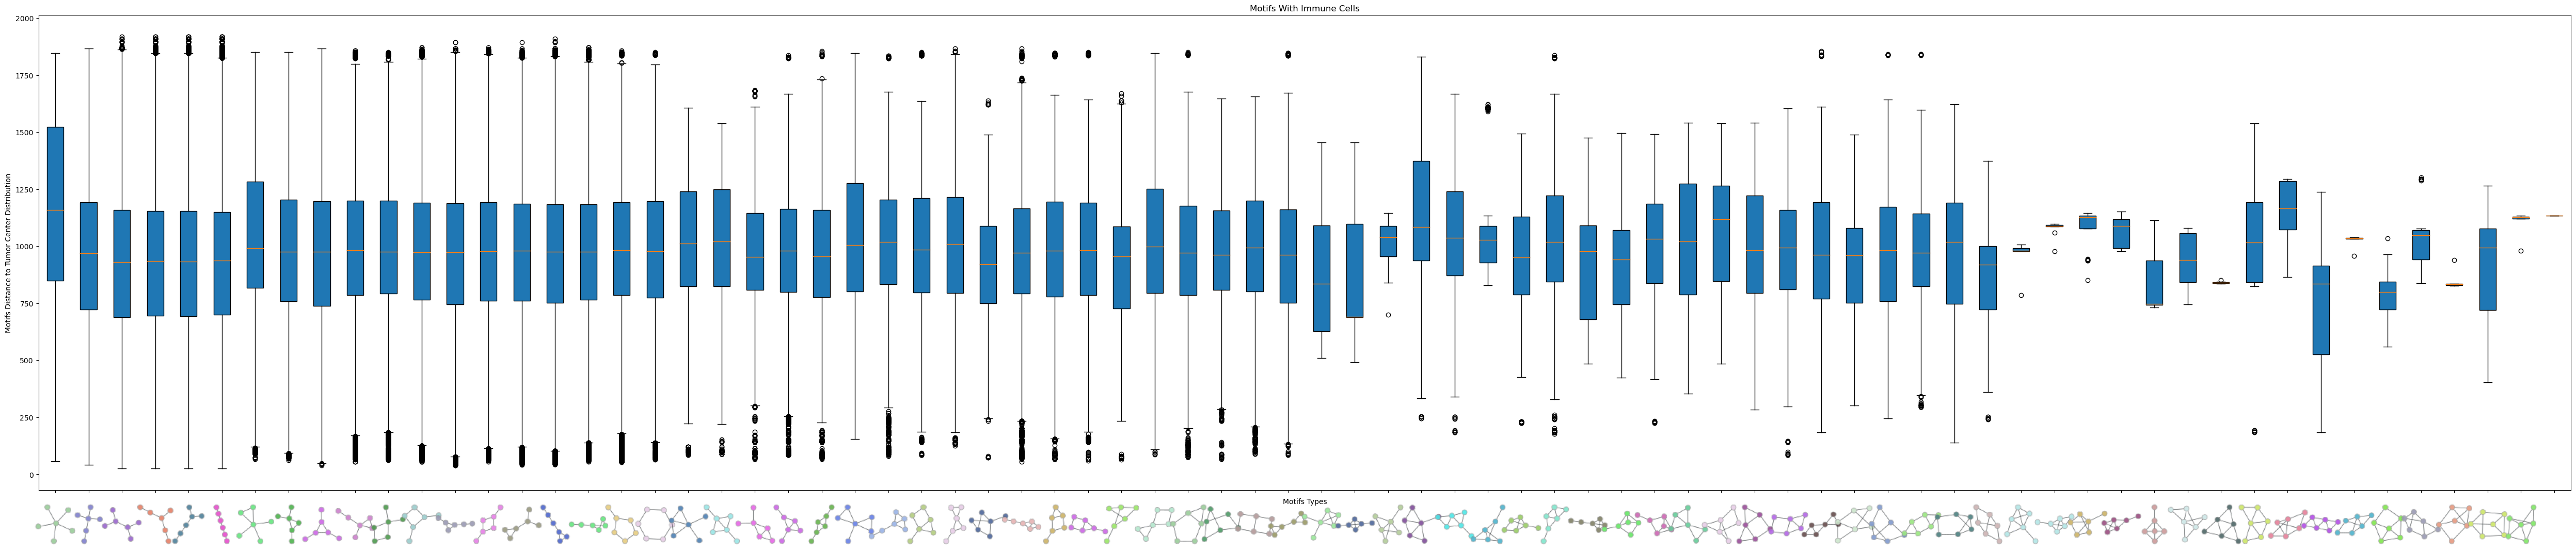

In [67]:
motifs_types = list(data_to_plot_by_motif_index.keys())
fig, axis = plt.subplots(figsize=(50,10))

data_to_plot = [x.flatten().tolist() for x in data_to_plot_by_motif_index.values()]
bplot1 = axis.boxplot(data_to_plot, patch_artist=True, notch=False)
axis.set_title("Motifs With Immune Cells")
axis.set_xlabel("Motifs Types")
# axis.set_xticks(np.arange(1, 7, 1))
axis.set_xticklabels([])
axis.set_ylabel("Motifs Distance to Tumor Center Distribution")
# data_to_plot = list(data_to_plot_by_motif_index.values())
# bplot2 = axis[1].boxplot(data_to_plot, patch_artist=True, notch=True)
# axis[1].set_title("Motifs Without Immune Cells")
# axis[1].set_xlabel("Motifs Types")
# axis[1].set_xticks(np.arange(1, 7, 1))
# axis[1].set_xticklabels([])
# axis[1].set_ylabel("")

for i, motif_type in enumerate(motifs_types):
    motif_path = os.path.join('motif_mapping_maps_dir', 'motifs_images_by_idx', f'Motif_{i+1}.png')
    try:
        img = plt.imread(motif_path)
        im = OffsetImage(img, zoom=1)
        im.image.axes = axis
        ab = AnnotationBbox(im, (i+1, 0), xybox=(0., -70.), frameon=False,
                            xycoords='data', boxcoords="offset points", pad=0)

        axis.add_artist(ab)
    except:
        continue


# colors = ['blue', 'red']
# for clr, bplot in zip(colors, [bplot1, bplot2]):
#     for patch in bplot['boxes']:
#         patch.set_facecolor(clr)

#
# for ax in axis:
#     ax.yaxis.grid(True)


plt.tight_layout()
# plt.savefig("motifs_size6_distance_to_tumor_center.eps")
# plt.savefig("motifs_size6_distance_to_tumor_center.png")
plt.show()

In [59]:
len(data_to_plot_by_motif_index)

76

In [49]:
data_to_plot[0]

[[1280.0402338566141],
 [1288.4049858575497],
 [1285.382913075432],
 [1418.7380982264547],
 [1413.9610228840247],
 [1403.119595875764],
 [1413.4819083373077],
 [1244.8307263225265],
 [1205.6483539513852],
 [1178.9034087709504],
 [1193.6677278796533],
 [1425.787971066354],
 [1426.2960253196582],
 [1424.1600979256477],
 [1419.890328106757],
 [1425.787971066354],
 [1458.2225785658375],
 [1424.1600979256477],
 [1419.890328106757],
 [1425.787971066354],
 [1458.2225785658375],
 [1426.2960253196582],
 [1424.1600979256477],
 [1352.6335689736782],
 [1265.0825281751386],
 [1199.1600648578387],
 [1255.347860423799],
 [1255.3016173020355],
 [1256.3306891182285],
 [1254.026765322426],
 [1277.7010119520792],
 [1246.030515056354],
 [1218.5909469284284],
 [1218.684915813244],
 [1205.6483539513852],
 [1254.6326270760724],
 [1256.3306891182285],
 [1254.026765322426],
 [1250.1547302551492],
 [1256.3306891182285],
 [1278.001722894746],
 [1285.382913075432],
 [1277.7010119520792],
 [911.7788328096625],
 [9

## Calculate edge probability to include immune cells if an edge in the same motif instance with at least one other edge with immune cells:

In [42]:
from itertools import combinations, permutations
from functools import reduce
def get_edge_probability_for_attribute_given_other_edge_in_motif_instance_attribute(g: Graph,
                                                                              motifs_vertices_lsts_dict: Dict[Graph, List[List[int]]],
                                                                              #motifs_vertices_lst: List[List[int]] = None,
                                                                               attribute_to_aggregate:Tuple[str, str]=('e', 'artery_binary'),
                                                                              ):
    n_motifs_instances_with_singleOrMore_attribute_presence_dict = {}  # for each motif type (key), the number of instances with a single or more (>=1) attribute appearance in all motif instance edges
    n_motifs_instances_with_multiple_attribute_presence_dict = {}  # for each motif type (key), the number of instances with multiple (>>1) attribute appearance in all motif instance edges

    for motif_type, motif_type_vertices_lsts in motifs_vertices_lsts_dict.items():
        visited_edges_in_motif_type = set()
        for vertices_lst in motif_type_vertices_lsts: # iterate each detected motif instance of the type vertices list (the vertices of the specific instance of the motif)
            # create the possible edges in the motif:
            possible_edges = combinations(vertices_lst.a, 2)
            possible_edges = list(possible_edges)
            # filter the edges not really in the graph, hence not in the motif:
            existing_edges_in_motif = map(lambda vertices: g.edge(vertices[0], vertices[1]), list(filter(lambda vertices: g.edge(vertices[0], vertices[1]) is not None, possible_edges)))
            n_attribute_exists_in_motif_instance_edges = reduce(lambda prev, _edge: prev + g.properties[attribute_to_aggregate][_edge], existing_edges_in_motif, 0)
            if n_attribute_exists_in_motif_instance_edges == 0:
                continue
            if n_attribute_exists_in_motif_instance_edges >= 1:
                n_motifs_instances_with_singleOrMore_attribute_presence_dict[motif_type] = n_motifs_instances_with_singleOrMore_attribute_presence_dict.get(motif_type, 0) + 1
                if n_attribute_exists_in_motif_instance_edges > 1:
                    n_motifs_instances_with_multiple_attribute_presence_dict[motif_type] = n_motifs_instances_with_multiple_attribute_presence_dict.get(motif_type, 0) + 1

    motifs_prob_e2_given_e1 = {
        _motif_type: n_motifs_instances_with_multiple_attribute_presence_dict.get(_motif_type, 0)/n_motifs_instances_with_singleOrMore_attribute_presence_dict.get(_motif_type, 1) for _motif_type in motifs_vertices_lsts_dict.keys()
    }


    return motifs_prob_e2_given_e1

In [43]:
by_motif_prob_e2_given_e1_dict = get_edge_probability_for_attribute_given_other_edge_in_motif_instance_attribute(g=g,
                                                                               motifs_vertices_lsts_dict=motifs_vertices_lsts_dict)

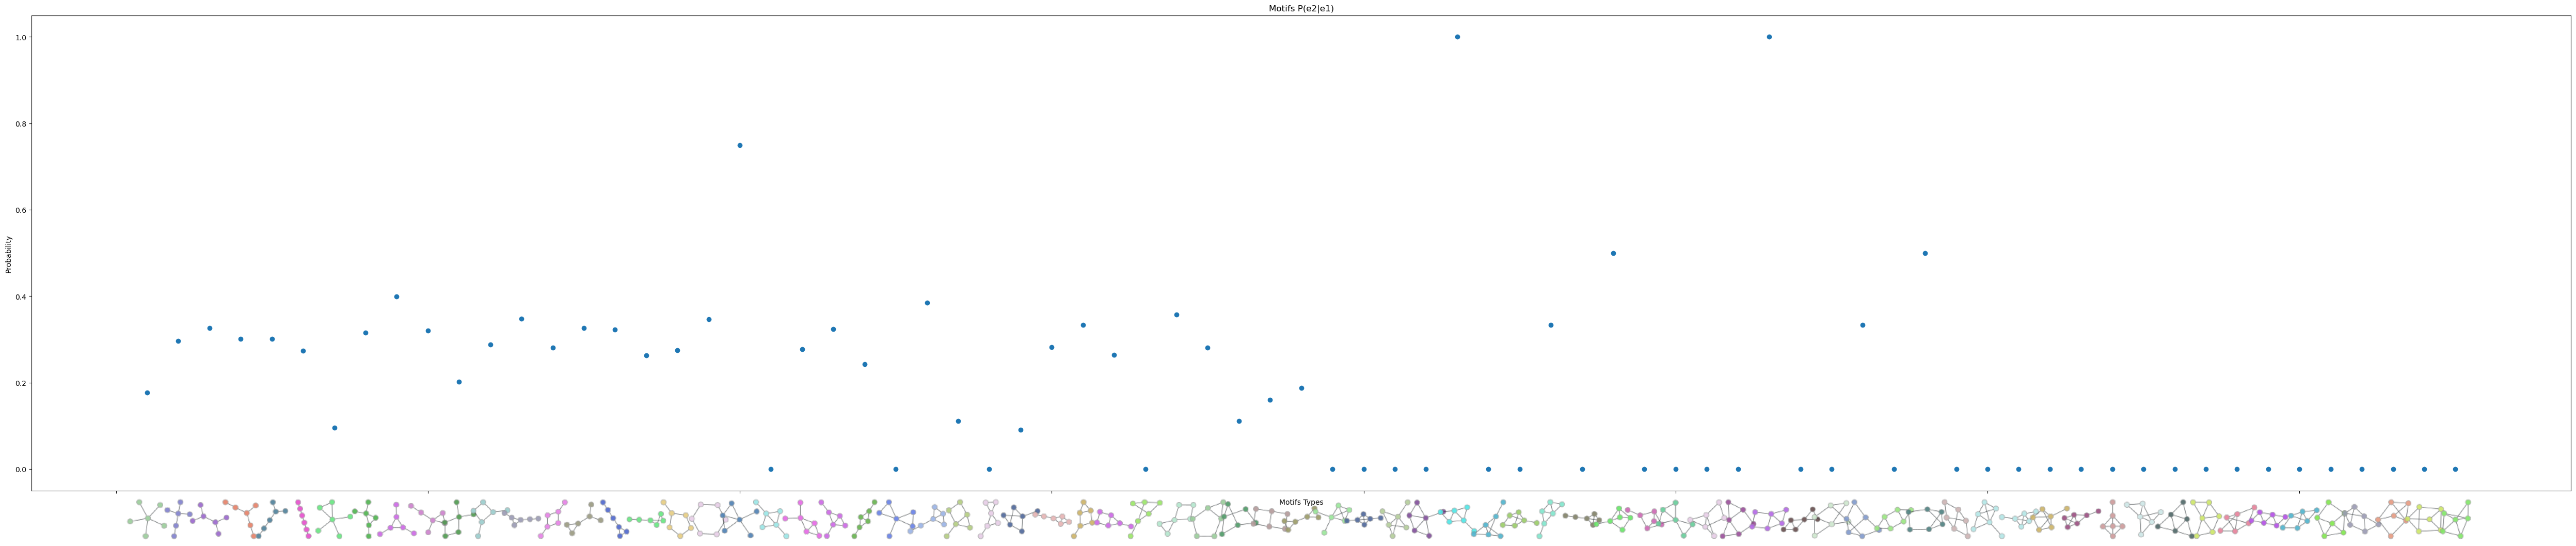

In [66]:
motifs_types = list(by_motif_prob_e2_given_e1_dict.keys())
fig, axis = plt.subplots(figsize=(50,10))

data_to_plot = [x for x in by_motif_prob_e2_given_e1_dict.values()]
axis.scatter(np.arange(1, len(data_to_plot)+1, 1), data_to_plot)
axis.set_title("Motifs P(e2|e1)")
axis.set_xlabel("Motifs Types")
# axis.set_xticks(np.arange(1, 7, 1))
axis.set_xticklabels([])
axis.set_ylabel("Probability")
# data_to_plot = list(data_to_plot_by_motif_index.values())
# bplot2 = axis[1].boxplot(data_to_plot, patch_artist=True, notch=True)
# axis[1].set_title("Motifs Without Immune Cells")
# axis[1].set_xlabel("Motifs Types")
# axis[1].set_xticks(np.arange(1, 7, 1))
# axis[1].set_xticklabels([])
# axis[1].set_ylabel("")

for i, motif_type in enumerate(motifs_types):
    motif_path = os.path.join('motif_mapping_maps_dir', 'motifs_images_by_idx', f'Motif_{i+1}.png')
    img = plt.imread(motif_path)
    im = OffsetImage(img, zoom=1)
    im.image.axes = axis
    ab = AnnotationBbox(im, (i+1, 0), xybox=(0., -70.), frameon=False,
                        xycoords='data', boxcoords="offset points", pad=0)

    axis.add_artist(ab)

# colors = ['blue', 'red']
# for clr, bplot in zip(colors, [bplot1, bplot2]):
#     for patch in bplot['boxes']:
#         patch.set_facecolor(clr)

#
# for ax in axis:
#     ax.yaxis.grid(True)


plt.tight_layout()
# plt.savefig("motifs_size6_p(e2_with_immune|e1_with_immune).eps")
# plt.savefig("motifs_size6_p(e2_with_immune|e1_with_immune).png")
plt.show()

# Immune cells presence as a target variable for Node2Vec embeddings:

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [48]:
df_full_path = ""
gbm_node2vec_embeddings_df = pd.read_csv(df_full_path)

{<Graph object, undirected, with 6 vertices and 5 edges, at 0x1642eb5e0>: 0.17745302713987474,
 <Graph object, undirected, with 6 vertices and 5 edges, at 0x16430c550>: 0.2967948717948718,
 <Graph object, undirected, with 6 vertices and 5 edges, at 0x16430e7a0>: 0.3259597176794629,
 <Graph object, undirected, with 6 vertices and 5 edges, at 0x1642558d0>: 0.30082764162314185,
 <Graph object, undirected, with 6 vertices and 5 edges, at 0x16430d5a0>: 0.3015852804482078,
 <Graph object, undirected, with 6 vertices and 5 edges, at 0x16430e1a0>: 0.2735251600468094,
 <Graph object, undirected, with 6 vertices and 6 edges, at 0x1642e96c0>: 0.09615384615384616,
 <Graph object, undirected, with 6 vertices and 6 edges, at 0x16430c640>: 0.3155737704918033,
 <Graph object, undirected, with 6 vertices and 6 edges, at 0x16430da80>: 0.39919354838709675,
 <Graph object, undirected, with 6 vertices and 6 edges, at 0x16430d0f0>: 0.32057416267942584,
 <Graph object, undirected, with 6 vertices and 6 edges

In [ ]:
embeddings_dim_size = 128
embeddings_columns_names = [f"embd_{i}" for i in range(embeddings_dim_size)]
pca_module = PCA(n_components=2)
tsne_module = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)

In [ ]:
vertices_embeddings = gbm_node2vec_embeddings_df.loc[:, embeddings_columns_names]

vertices_embeddings_pca = pca_module.fit_transform(vertices_embeddings)
vertices_embeddings_tsne = tsne_module.fit_transform(vertices_embeddings)
gbm_node2vec_embeddings_df['pc_0'] = vertices_embeddings_pca[:, 0]
gbm_node2vec_embeddings_df['pc_1'] = vertices_embeddings_pca[:, 1]
gbm_node2vec_embeddings_df['tsne_0'] = vertices_embeddings_tsne[:, 0]
gbm_node2vec_embeddings_df['tsne_1'] = vertices_embeddings_tsne[:, 1]

In [ ]:
import graph_tool.all as gt
def calc_vertex_edges_immune_cell_presence(g: gt.Graph,
                                           v_id: int,
                                           edge_prop_name: str = 'artery_raw',
                                           **kwargs) -> Tuple[float,...]:
    v = g.vertex(v_id)
    v_edges = v.all_edges()
    immune_counts_in_v_edges = np.array([g.ep[edge_prop_name][_e] for _e in v_edges])
    immune_counts_in_v_edges_sum = immune_counts_in_v_edges.sum()
    immune_counts_in_v_edges_std = np.std(immune_counts_in_v_edges)
    immune_counts_in_v_edges_n_edges_with_presence = (immune_counts_in_v_edges>0).sum()
    immune_counts_in_v_edges_fraction_edges_with_presence = ((immune_counts_in_v_edges>0).sum()/immune_counts_in_v_edges.size)

    return immune_counts_in_v_edges_std, immune_counts_in_v_edges_n_edges_with_presence, immune_counts_in_v_edges_fraction_edges_with_presence

In [ ]:
gbm_graph_path = ""
gbm_graph = gt.load_graph(gbm_graph_path)
gbm_node2vec_embeddings_df.loc[:, ["counts_in_v_edges_sum", "counts_in_v_edges_std", "counts_in_v_edges_n_edges_with_presence" ,"counts_in_v_edges_fraction_edges_with_presence"]] = gbm_node2vec_embeddings_df.apply(lambda x: calc_vertex_edges_immune_cell_presence(g=gbm_graph,v_id=x), axis=1)

In [ ]:
target_variable = 'is_present'
gbm_node2vec_embeddings_df[target_variable] = gbm_node2vec_embeddings_df.loc[:, ["counts_in_v_edges_sum"]].apply(lambda x: x>0, axis=1)

In [ ]:
from sklearn.model_selection import train_test_split
features = gbm_node2vec_embeddings_df.loc[:, embeddings_columns_names].values
labels = gbm_node2vec_embeddings_df.loc[:, [target_variable]].values
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, shuffle=True, stratify=labels)

In [ ]:
from sklearn.svm import SVC
svc = SVC(degree=3)
svc.fit(x_train, y_train)
svc.score(x_test, y_test)